In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
file_path = 'Lab3/Unipol_dataset_lab3.csv' 
data = pd.read_csv(file_path)

In [4]:
# Inspecting a single trip (e.g., Vehicle 1, Trip 0)
trip_inspection = data[(data['vehicle_id'] == 1) & (data['trip_id'] == 100)]
print(trip_inspection[['road', 'total_distance', 'start_time', 'stop_time', 'trip_id']])

    road  total_distance           start_time            stop_time  trip_id
158    A           83.43  2023-10-06 19:11:32  2023-10-06 21:41:05      100
159    E           53.09  2023-10-06 19:11:32  2023-10-06 21:41:05      100
160    U            8.06  2023-10-06 19:11:32  2023-10-06 21:41:05      100


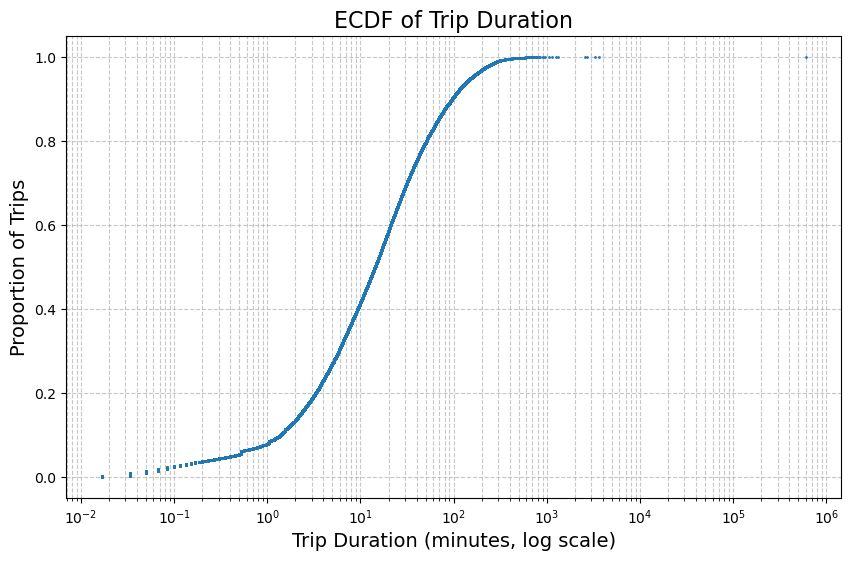

In [5]:

# Check for missing values 
data.dropna(subset=['start_time', 'stop_time'], inplace=True)

data['start_time'] = pd.to_datetime(data['start_time'])
data['stop_time'] = pd.to_datetime(data['stop_time'])


# We only want one record per trip to calculate duration correctly.
unique_trips = data.drop_duplicates(subset=['vehicle_id', 'trip_id']).copy()

# Calculate Duration (in minutes)
unique_trips['trip_duration'] = (unique_trips['stop_time'] - unique_trips['start_time']).dt.total_seconds() / 60

# Filter out zero/negative durations (essential for log scale)
unique_trips = unique_trips[unique_trips['trip_duration'] > 0]

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

plt.figure(figsize=(10, 6))

x, y = ecdf(unique_trips['trip_duration'])

# Plotting
plt.plot(x, y, marker='.', linestyle='none', markersize=2) 

plt.title('ECDF of Trip Duration', fontsize=16)
plt.xlabel('Trip Duration (minutes, log scale)', fontsize=14)
plt.ylabel('Proportion of Trips', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Set Log Scale
plt.xscale('log')

plt.show()

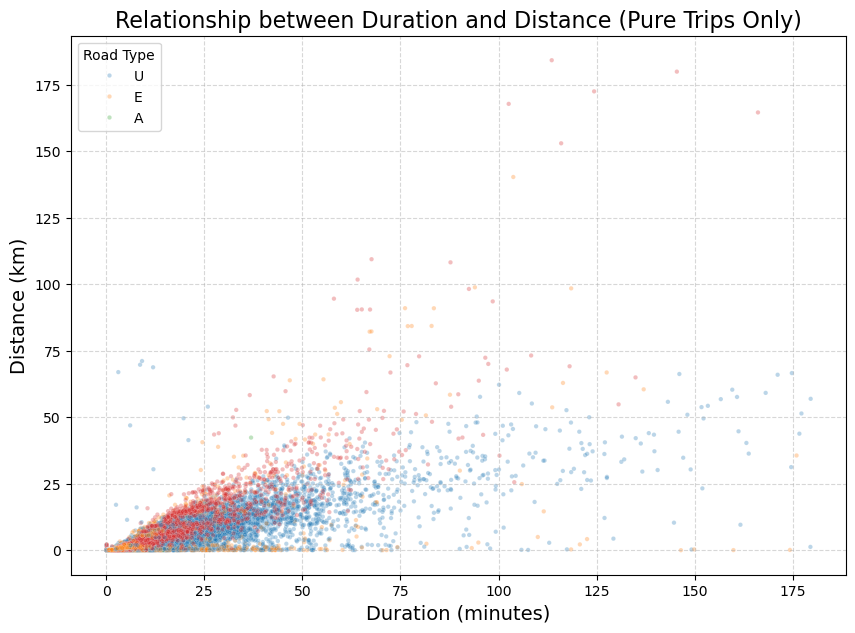

In [6]:
# Convert timestamps
data['start_time'] = pd.to_datetime(data['start_time'])
data['stop_time'] = pd.to_datetime(data['stop_time'])

# Calculate Duration
data['duration_min'] = (data['stop_time'] - data['start_time']).dt.total_seconds() / 60

# Filter for "Pure" Trips (Trips with only 1 road segment)
# We group by Trip ID and keep only groups with exactly 1 row.
# This removes "Mixed" trips (e.g., Urban + Highway) where data is misleading.
trip_counts = data.groupby(['vehicle_id', 'trip_id']).size()
pure_trip_indices = trip_counts[trip_counts == 1].index

# Select these trips from the main dataframe
pure_trips = data.set_index(['vehicle_id', 'trip_id']).loc[pure_trip_indices].reset_index()

# Filter for reasonable limits to make the plot readable (remove extreme outliers)
pure_trips = pure_trips[(pure_trips['total_distance'] < 200) & (pure_trips['duration_min'] < 180)]
pure_trips = pure_trips[pure_trips['total_distance'] > 0] # Remove 0 distance

# Plot Scatter Graph
plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=pure_trips, 
    x='duration_min', 
    y='total_distance', 
    hue='road', 
    alpha=0.3, 
    s=10       
)

plt.title('Relationship between Duration and Distance (Pure Trips Only)', fontsize=16)
plt.xlabel('Duration (minutes)', fontsize=14)
plt.ylabel('Distance (km)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Road Type')

plt.show()

In [12]:
data['start_time'] = pd.to_datetime(data['start_time'])
data['stop_time'] = pd.to_datetime(data['stop_time'])

data_cleaned_ = data.dropna(subset=['road', 'total_distance', 'start_time', 'stop_time']).copy()

print(f"Number of records before filtering: {len(data_cleaned_)}")

trips_aggregated = data_cleaned_.groupby(['vehicle_id', 'trip_id']).agg({
    'start_time': 'min',         
    'stop_time': 'max',
    'total_distance': 'sum'        
}).reset_index()

# Recalculate duration on the aggregated data
trips_aggregated['trip_duration'] = (trips_aggregated['stop_time'] - trips_aggregated['start_time']).dt.total_seconds() / 60

# Define filtering criteria
min_distance = 0.1
max_distance = 1000
min_duration = 2
max_duration = 600
min_speed = 1
max_speed = 200

# Filter dataset
filtered_trips = trips_aggregated[
    (trips_aggregated['total_distance'] > min_distance) &
    (trips_aggregated['total_distance'] <= max_distance) &
    (trips_aggregated['trip_duration'] > min_duration) &
    (trips_aggregated['trip_duration'] <= max_duration)
].copy()

# Calculate average speed (km/h) using TOTAL distance and TOTAL time
filtered_trips['average_speed'] = (
    filtered_trips['total_distance'] / (filtered_trips['trip_duration'] / 60)
)

# Filter based on speed
filtered_trips = filtered_trips[
    (filtered_trips['average_speed'] >= min_speed) &
    (filtered_trips['average_speed'] <= max_speed)
]

# Count valid trips
valid_trip_count = len(filtered_trips)

print("Filtering Criteria:")
print(f"1. Total distance > {min_distance} km and <= {max_distance} km")
print(f"2. Trip duration > {min_duration} minutes and <= {max_duration} minutes")
print(f"3. Average speed between {min_speed} km/h and {max_speed} km/h")
print(f"Number of valid trips: {valid_trip_count}")

Number of records before filtering: 70126
Filtering Criteria:
1. Total distance > 0.1 km and <= 1000 km
2. Trip duration > 2 minutes and <= 600 minutes
3. Average speed between 1 km/h and 200 km/h
Number of valid trips: 35446


**1.**  Analysing behaviours of vehicles. For each vehicle, aggregate the data on daily basis, compute following values:
- number of trips
- total distance
- utilization percetage

In [8]:
filtered_trips.head()

,vehicle_id,trip_id,start_time,stop_time,total_distance,trip_duration,average_speed
0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,15.78,16.116667,58.746639
2,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,4.60,14.866667,18.565022
3,1,3,2023-09-29 15:37:38,2023-09-29 15:57:26,4.25,19.800000,12.878788
6,1,6,2023-09-30 05:05:39,2023-09-30 05:28:37,1.21,22.966667,3.161103
8,1,8,2023-09-30 06:07:07,2023-09-30 06:33:53,5.08,26.766667,11.387298


In [8]:
df = filtered_trips.copy() 

# Extract Date and Day Type
df['date'] = df['start_time'].dt.date
df['day_type'] = df['start_time'].dt.weekday.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Aggregate by Vehicle and Date 
daily_aggregation = df.groupby(['vehicle_id', 'date', 'day_type']).agg(
    num_trips=('trip_id', 'count'),            # Simply count the trips
    total_distance=('total_distance', 'sum'),  # Sum of distances
    total_duration_min=('trip_duration', 'sum') # Sum of durations
).reset_index()

# Calculate Utilization Percentage
# (Total Minutes Driven / Minutes in a Day) * 100
# daily_aggregation['daily_utilization'] = (daily_aggregation['total_duration_min'] / 1440)   
daily_aggregation['daily_utilization'] = daily_aggregation.groupby(['vehicle_id', 'date'])['total_duration_min'].transform('sum') / (24 * 60)  # 24 hours


# Check the results
print(daily_aggregation.head())
print(f"Max Utilization: {daily_aggregation['daily_utilization'].max():.2f}")

   vehicle_id        date day_type  num_trips  total_distance  \
0           1  2023-09-29  Weekday          3          24.630   
1           1  2023-09-30  Weekend          6          11.180   
2           1  2023-10-01  Weekend          1         361.539   
3           1  2023-10-02  Weekday          7         725.195   
4           1  2023-10-03  Weekday          8         519.620   

   total_duration_min  daily_utilization  
0           50.783333           0.035266  
1           69.066667           0.047963  
2          268.983333           0.186794  
3          562.733333           0.390787  
4          478.316667           0.332164  
Max Utilization: 1.79


In [9]:
import pandas as pd

# 1. Load and Preprocess
# We assume 'filtered_trips' contains the valid segments from your previous steps
# If starting from scratch, we ensure 'date' is created:
filtered_trips = pd.read_csv('Unipol_dataset_lab3.csv') # Or use your existing filtered_trips
filtered_trips['start_time'] = pd.to_datetime(filtered_trips['start_time'])

# --- THIS LINE FIXES YOUR ERROR ---
filtered_trips['date'] = filtered_trips['start_time'].dt.date 
# ----------------------------------

# 2. RUN THE COMPARISON

# Method A: Correct (Group by Date ONLY)
# Counts unique trip_ids per day. Even if a trip has 3 segments, it counts as 1.
daily_correct = filtered_trips.groupby(['vehicle_id', 'date']).agg(
    true_trip_count=('trip_id', 'nunique')
).reset_index()

# Method B: Inflated (Group by Road, Then Sum)
# Counts unique trip_ids per road bucket, then adds them up.
road_grouped = filtered_trips.groupby(['vehicle_id', 'date', 'road']).agg(
    road_segment_count=('trip_id', 'nunique')
).reset_index()

daily_inflated = road_grouped.groupby(['vehicle_id', 'date']).agg(
    inflated_trip_count=('road_segment_count', 'sum')
).reset_index()

# 3. Merge and Find Errors
comparison = pd.merge(daily_correct, daily_inflated, on=['vehicle_id', 'date'])
comparison['error_diff'] = comparison['inflated_trip_count'] - comparison['true_trip_count']

# Show the worst offenders
discrepancies = comparison[comparison['error_diff'] > 0].sort_values('error_diff', ascending=False)

print(f"Total Vehicle-Days Analyzed: {len(comparison)}")
print(f"Days with Double-Counting Errors: {len(discrepancies)}")
print("\n--- Top 5 Examples of the Error ---")
print(discrepancies.head(5))

# Example Breakdown for the top result
if not discrepancies.empty:
    top_row = discrepancies.iloc[0]
    vid, date = top_row['vehicle_id'], top_row['date']
    print(f"\nExample: Vehicle {vid} on {date}")
    print(f" - True Trips: {top_row['true_trip_count']}")
    print(f" - Inflated Count: {top_row['inflated_trip_count']} (Error: +{top_row['error_diff']})")

Total Vehicle-Days Analyzed: 56646
Days with Double-Counting Errors: 52503

--- Top 5 Examples of the Error ---
       vehicle_id        date  true_trip_count  inflated_trip_count  \
56325         994  2023-11-16               62                  115   
56287         994  2023-10-09               57                  110   
56284         994  2023-10-06               62                  114   
17449         307  2023-10-02               57                  107   
56289         994  2023-10-11               54                  104   

       error_diff  
56325          53  
56287          53  
56284          52  
17449          50  
56289          50  

Example: Vehicle 994 on 2023-11-16
 - True Trips: 62
 - Inflated Count: 115 (Error: +53)


- 1.a 

In [10]:

# Create 'date' and 'day_type' columns
df['date'] = df['start_time'].dt.date
df['day_type'] = df['start_time'].dt.weekday.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

#Group by Vehicle and Date ONLY 
daily_stats = df.groupby(['vehicle_id', 'date', 'day_type']).agg(
    daily_distance=('total_distance', 'sum'),
    daily_duration=('trip_duration', 'sum'),
    daily_trips=('trip_id', 'count')
).reset_index()

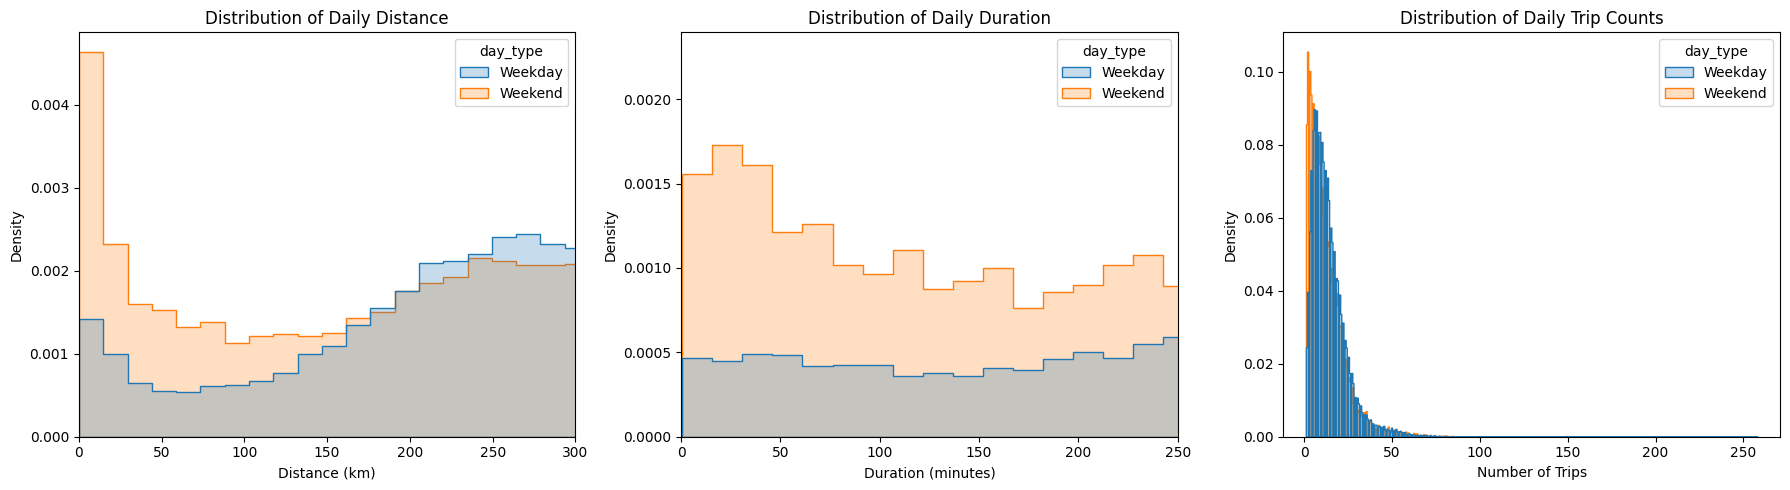

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot A: Daily Distance
sns.histplot(data=daily_stats, x='daily_distance', hue='day_type', 
             element='step', stat='density', common_norm=False, ax=axes[0])
axes[0].set_title('Distribution of Daily Distance')
axes[0].set_xlabel('Distance (km)')
axes[0].set_xlim(0, 300) 

# Plot B: Daily Duration
sns.histplot(data=daily_stats, x='daily_duration', hue='day_type', 
             element='step', stat='density', common_norm=False, ax=axes[1])
axes[1].set_title('Distribution of Daily Duration')
axes[1].set_xlabel('Duration (minutes)')
axes[1].set_xlim(0, 250)

# Plot C: Number of Trips
sns.histplot(data=daily_stats, x='daily_trips', hue='day_type', 
             element='step', stat='density', common_norm=False, ax=axes[2])
axes[2].set_title('Distribution of Daily Trip Counts')
axes[2].set_xlabel('Number of Trips')

plt.tight_layout()
plt.show()

In [12]:
print("\n--- Statistics: Weekday vs Weekend ---")
summary_stats = daily_stats.groupby('day_type')[['daily_distance', 'daily_duration', 'daily_trips']].describe(percentiles=[0.5])
print(summary_stats.T)


# Calculate Standard Deviation of daily distance for each vehicle
vehicle_consistency = daily_stats.groupby('vehicle_id')['daily_distance'].std()

print("\n--- Top 5 Most Consistent Vehicles (Lowest Std Dev) ---")
print(vehicle_consistency.sort_values().head(5))

print("\n--- Top 5 Least Consistent Vehicles (Highest Std Dev) ---")
print(vehicle_consistency.sort_values(ascending=False).head(5))


--- Statistics: Weekday vs Weekend ---
day_type                   Weekday       Weekend
daily_distance count  41565.000000  13810.000000
               mean     398.028504    304.930555
               std      253.371526    225.804191
               min        0.110000      0.102000
               50%      339.790000    282.295000
               max     2113.040000   2046.935000
daily_duration count  41565.000000  13810.000000
               mean     531.246032    436.812172
               std      223.729155    267.925252
               min        0.533333      1.266667
               50%      541.316667    443.658333
               max     2574.600000   2509.266667
daily_trips    count  41565.000000  13810.000000
               mean      14.280284     12.478494
               std       11.690690     12.347094
               min        1.000000      1.000000
               50%       12.000000      9.000000
               max      258.000000    237.000000

--- Top 5 Most Consistent Ve

4. conduct the simulation of all the vehicles, with different parameters(types of EV and charging power) and analyse the result 

In [13]:
# prepare data

df = pd.read_csv('Unipol_dataset_lab3.csv')

# Convert timestamps
df['start_time'] = pd.to_datetime(df['start_time'])
df['stop_time'] = pd.to_datetime(df['stop_time'])

# Sort chronologically 
ordered_trips = df.sort_values(by=['vehicle_id', 'start_time']).copy()


print(f"Data Loaded: {len(ordered_trips)} rows ready for simulation.")

Data Loaded: 1415305 rows ready for simulation.


In [14]:
ordered_trips.head()

,Unnamed: 0,vehicle_id,trip_id,start_time,stop_time,road,total_distance
0,0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,E,14.31
1,1,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,U,1.47
2,2,1,1,2023-09-29 14:32:24,2023-09-29 14:34:31,U,0.03
3,3,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,E,2.60
4,4,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,U,2.00


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi


# Global Thresholds
FAST_CHARGING_SOC_THRESHOLD = 0.20  # < 20% SoC
FAST_CHARGING_TIME_THRESHOLD = 2.0  # < 2 Hours

cars_config = {
    "Renault Twingo (27kWh)": {
        "capacity": 27.5, "ac_power": 6.6, "dc_power": 50.0,
        "consumption": {"U": 0.096, "A": 0.162, "E": 0.128, "_": 0.128}
    },
    "Fiat 500e (37kWh)": {
        "capacity": 37.3, "ac_power": 11.0, "dc_power": 85.0,
        "consumption": {"U": 0.105, "A": 0.173, "E": 0.138, "_": 0.138}
    },
    "CUPRA Born (77kWh)": {
        "capacity": 77.0, "ac_power": 11.0, "dc_power": 175.0,
        "consumption": {"U": 0.118, "A": 0.186, "E": 0.150, "_": 0.150}
    },
    "BYD SEAL (82.5kWh)": {
        "capacity": 82.5, "ac_power": 11.0, "dc_power": 150.0,
        "consumption": {"U": 0.121, "A": 0.181, "E": 0.149, "_": 0.149}
    },
    "BMW iX (71kWh)": {
        "capacity": 71.0, "ac_power": 11.0, "dc_power": 148.0,
        "consumption": {"U": 0.138, "A": 0.215, "E": 0.175, "_": 0.175}
    },
    "Lotus Eletre (109kWh)": {
        "capacity": 109.0, "ac_power": 22.0, "dc_power": 367.0,
        "consumption": {"U": 0.156, "A": 0.242, "E": 0.196, "_": 0.196}
    },
    "VW ID.Buzz (77kWh)": {
        "capacity": 77.0, "ac_power": 11.0, "dc_power": 175.0,
        "consumption": {"U": 0.154, "A": 0.252, "E": 0.200, "_": 0.200}
    },
    "Audi e-tron GT (85kWh)": {
        "capacity": 85.0, "ac_power": 11.0, "dc_power": 268.0,
        "consumption": {"U": 0.150, "A": 0.227, "E": 0.185, "_": 0.185}
    }
}

def init_metrics_structure():
    """Initializes the exact metrics dictionary from Pseudocode"""
    return {
        "feasibility": {
            "total_trips": 0, "feasible_trips": 0, "unfeasible_trips": 0
        },
        "battery_perf": {
            "soc_values": [], "soc_below_20_count": 0
        },
        "charging": {
            "total_events": 0, "total_time_hours": 0.0,
            "slow_events": 0, "fast_events": 0,
            "durations": []
        },
        "energy": {
            "total_consumed_kwh": 0.0, "total_distance_km": 0.0
        }
    }

# ==============================================================================
# SIMULATION LOOP
# ==============================================================================
def run_simulation(trips_df, car_name, car_params):
    print(f"Simulating: {car_name}...")
    
    # Initialize Data
    trips = trips_df.sort_values(by=['vehicle_id', 'start_time']).copy()
    trip_log = [] # To store detailed trip results
    
    # Global metrics for this car model
    model_metrics = init_metrics_structure()

    # Vehicle Loop
    for vid, vehicle_trips in trips.groupby('vehicle_id'):
        
        # Initialize SoC
        battery_cap = car_params['capacity']
        current_soc = battery_cap
        
        trip_list = vehicle_trips.to_dict('records')
        
        # Trip Loop
        for i, trip in enumerate(trip_list):
            
            # --- Calculate Energy Required ---
            dist = trip['total_distance']
            road = trip['road'] if trip['road'] in ['U', 'A', 'E'] else '_'
            consumption_rate = car_params['consumption'][road]

            # how much energy is needed for this trip
            energy_needed = dist * consumption_rate
            
            # Tracking "SoC Before" for logging
            soc_before = current_soc
            status = "Feasible"

            # --- Check Feasibility ---
            model_metrics['feasibility']['total_trips'] += 1
            
            if current_soc >= energy_needed:
                # Feasible
                current_soc -= energy_needed
                
                # Update Metrics
                model_metrics['feasibility']['feasible_trips'] += 1
                model_metrics['energy']['total_consumed_kwh'] += energy_needed
                model_metrics['energy']['total_distance_km'] += dist
                model_metrics['battery_perf']['soc_values'].append(current_soc / battery_cap * 100)
                
                if (current_soc / battery_cap) < 0.20:
                    model_metrics['battery_perf']['soc_below_20_count'] += 1
            else:
                # Unfeasible
                status = "Unfeasible"
                model_metrics['feasibility']['unfeasible_trips'] += 1
                current_soc = battery_cap * 0.20  #reset the battery to 20% after unfeasible trip
            
            soc_after = current_soc

            # --- Calculate Parking Duration ---
            parking_time = 0
            charge_type = "None"
            energy_recharged = 0
            
            if i < len(trip_list) - 1:
                next_start = trip_list[i+1]['start_time']
                current_end = trip['stop_time']
                parking_time = max(0, (next_start - current_end).total_seconds() / 3600)
                
                # --- Charging Logic ---
                if parking_time > 0:
                    power = 0
                    
                    # Determine Charging Type
                    is_low_soc = current_soc < (FAST_CHARGING_SOC_THRESHOLD * battery_cap)
                    is_short_stop = (parking_time < FAST_CHARGING_TIME_THRESHOLD) and (current_soc < (battery_cap * 0.8))
                    
                    if is_low_soc or is_short_stop:
                        # Fast Charging
                        power = car_params['dc_power']
                        charge_type = "Fast (DC)"
                        model_metrics['charging']['fast_events'] += 1
                    else:
                        # Slow Charging
                        power = car_params['ac_power']
                        charge_type = "Slow (AC)"
                        model_metrics['charging']['slow_events'] += 1
                    
                    # Calculate Energy Recharged
                    energy_needed_to_full = battery_cap - current_soc
                    time_to_full = energy_needed_to_full / power if power > 0 else 0
                    actual_charging_time = min(parking_time, time_to_full)
                    
                    # Update Battery
                    energy_recharged = power * actual_charging_time
                    current_soc = min(current_soc + energy_recharged, battery_cap) # Cap at 100% => gets the soc and do not exceed capacity
                    
                    # Update Charging Metrics
                    model_metrics['charging']['total_events'] += 1
                    model_metrics['charging']['total_time_hours'] += actual_charging_time
                    model_metrics['charging']['durations'].append(actual_charging_time)

            # --- Store Trip Results ---
            trip_log.append({
                'car_model': car_name,
                'vehicle_id': vid,
                'trip_id': trip.get('trip_id', i), # Safety get
                'soc_before': (soc_before / battery_cap) * 100,
                'soc_after': (soc_after / battery_cap) * 100,
                'status': status,
                'energy_consumed': energy_needed,
                'parking_time': parking_time,
                'charge_type': charge_type,
                'energy_recharged': energy_recharged
            })

    return pd.DataFrame(trip_log), model_metrics

# ==============================================================================
# EXECUTION & METRICS AGGREGATION
# ==============================================================================
all_trip_logs = []
model_summaries = []

for model_name, params in cars_config.items():
    
    # Run Simulation
    df_log, raw_metrics = run_simulation(ordered_trips, model_name, params)
    all_trip_logs.append(df_log)
    
    # Metrics Calculation (Aggregating the accumulated counts)
    f_metrics = raw_metrics['feasibility']
    b_metrics = raw_metrics['battery_perf']
    c_metrics = raw_metrics['charging']
    e_metrics = raw_metrics['energy']
    
    # Calculations
    total_trips = f_metrics['total_trips']
    feasible_pct = (f_metrics['feasible_trips'] / total_trips * 100) if total_trips > 0 else 0
    
    avg_soc = np.mean(b_metrics['soc_values']) if b_metrics['soc_values'] else 0
    min_soc = np.min(b_metrics['soc_values']) if b_metrics['soc_values'] else 0
    
    avg_charge_duration = (c_metrics['total_time_hours'] / c_metrics['total_events']) if c_metrics['total_events'] > 0 else 0
    fast_ratio = (c_metrics['fast_events'] / c_metrics['total_events'] * 100) if c_metrics['total_events'] > 0 else 0
    
    avg_energy_km = (e_metrics['total_consumed_kwh'] * 1000) / e_metrics['total_distance_km'] if e_metrics['total_distance_km'] > 0 else 0
    
    # Store Summary
    model_summaries.append({
        'Car Model': model_name,
        'Feasibility %': feasible_pct,
        'Unfeasible Trips': f_metrics['unfeasible_trips'],
        'Avg SoC (%)': avg_soc,
        'Min SoC (%)': min_soc,
        'SoC < 20% Count': b_metrics['soc_below_20_count'],
        'Total Charging Events': c_metrics['total_events'],
        'Avg Charge Duration (h)': avg_charge_duration,
        'Fast Charge Ratio (%)': fast_ratio,
        'Efficiency (Wh/km)': avg_energy_km,
        'Total Energy (kWh)': e_metrics['total_consumed_kwh']
    })

# Create Final DataFrames
final_trip_data = pd.concat(all_trip_logs)
comparison_df = pd.DataFrame(model_summaries)

print("\n--- Simulation Complete. Comparison Table Created. ---")
print(comparison_df[['Car Model', 'Feasibility %', 'Efficiency (Wh/km)', 'Fast Charge Ratio (%)']])



Simulating: Renault Twingo (27kWh)...
Simulating: Fiat 500e (37kWh)...
Simulating: CUPRA Born (77kWh)...
Simulating: BYD SEAL (82.5kWh)...
Simulating: BMW iX (71kWh)...
Simulating: Lotus Eletre (109kWh)...
Simulating: VW ID.Buzz (77kWh)...
Simulating: Audi e-tron GT (85kWh)...

--- Simulation Complete. Comparison Table Created. ---
                Car Model  Feasibility %  Efficiency (Wh/km)  \
0  Renault Twingo (27kWh)      97.407131          125.814716   
1       Fiat 500e (37kWh)      98.484638          137.898243   
2      CUPRA Born (77kWh)      99.780471          154.860158   
3      BYD SEAL (82.5kWh)      99.819120          153.588746   
4          BMW iX (71kWh)      99.460116          178.622163   
5   Lotus Eletre (109kWh)      99.857840          202.848339   
6      VW ID.Buzz (77kWh)      99.347985          204.509170   
7  Audi e-tron GT (85kWh)      99.721403          191.117020   

   Fast Charge Ratio (%)  
0              28.006070  
1              20.596793  
2       

### Metric calcultion :
1. **Feasibility:**
2. **Battery Performance:**
3. **Charging:**
4. **Energy Efficiency:**

In [16]:
final_report = comparison_df[[
    'Car Model', 
    'Feasibility %',           # 1. Feasibility
    'Avg SoC (%)',             # 2. Battery Performance (Mean)
    'Min SoC (%)',             # 2. Battery Performance (Min)
    'Avg Charge Duration (h)', # 3. Charging (Duration)
    'Fast Charge Ratio (%)',   # 3. Charging (Ratio)
    'Efficiency (Wh/km)'       # 4. Energy Efficiency
]].copy()

final_report['Feasibility %'] = final_report['Feasibility %'].map('{:.2f}%'.format)
final_report['Avg SoC (%)'] = final_report['Avg SoC (%)'].map('{:.1f}%'.format)
final_report['Min SoC (%)'] = final_report['Min SoC (%)'].map('{:.1f}%'.format)
final_report['Avg Charge Duration (h)'] = final_report['Avg Charge Duration (h)'].map('{:.2f} h'.format)
final_report['Fast Charge Ratio (%)'] = final_report['Fast Charge Ratio (%)'].map('{:.1f}%'.format)
final_report['Efficiency (Wh/km)'] = final_report['Efficiency (Wh/km)'].map('{:.1f} Wh/km'.format)

print("--- Final Performance Report per EV Model ---")
print(final_report.to_string(index=False))

--- Final Performance Report per EV Model ---
             Car Model Feasibility % Avg SoC (%) Min SoC (%) Avg Charge Duration (h) Fast Charge Ratio (%) Efficiency (Wh/km)
Renault Twingo (27kWh)        97.41%       78.0%        0.0%                  0.13 h                 28.0%        125.8 Wh/km
     Fiat 500e (37kWh)        98.48%       82.4%        0.0%                  0.10 h                 20.6%        137.9 Wh/km
    CUPRA Born (77kWh)        99.78%       88.1%        0.0%                  0.14 h                 11.2%        154.9 Wh/km
    BYD SEAL (82.5kWh)        99.82%       88.3%        0.0%                  0.15 h                 11.1%        153.6 Wh/km
        BMW iX (71kWh)        99.46%       85.7%        0.0%                  0.14 h                 15.2%        178.6 Wh/km
 Lotus Eletre (109kWh)        99.86%       90.1%        0.0%                  0.10 h                  8.4%        202.8 Wh/km
    VW ID.Buzz (77kWh)        99.35%       85.1%        0.0%            

1. **Feasibility:**

- Feasibility => Lotus Eletre (99.86%) and BYD SEAL (99.82%) are nearly perfect, their large batteries allow them to handle almost any trip in the simulation 

- Renault Twingo (97.41%) and Fiat 500e (98.48%) => lower performance but still high 

###### ------------------------------------------------------------------------------------------------------------------------------------------------------
######
2. **Battery Performance:**
- Avg SOC : avg battery level maintained during operation 
- Larger batteries maintain a higher "buffer." The Lotus Eletre sits comfortably at 90.1%, whereas the Twingo drops to 78.0%. This indicates the smaller cars are being pushed closer to their limits more frequently.
- Every single model hit a Minimum SoC of 0.0%.

###### ------------------------------------------------------------------------------------------------------------------------------------------------------
######
3. **Charging:**
- Fast Charge Ratio: The percentage of charging sessions that used high-power (DC) fast chargers rather than slow (AC) chargers.

- Small Batteries = More Stress: The Renault Twingo has the highest ratio at 28.0%. Because its range is short, it frequently needs "emergency" fast top-ups to keep working.

Large Batteries = More Flexibility: The Lotus Eletre has the lowest ratio (8.4%). It can likely complete its daily duties on a single charge and recharge slowly overnight.
###### ------------------------------------------------------------------------------------------------------------------------------------------------------
######
4. **Energy Efficiency:**

- How much energy is used per kilometer (Wh/km). Lower is better.
- Most Efficient: The Renault Twingo (125.8 Wh/km) is the most economical to run per kilometer, followed by the Fiat 500e.
- The VW ID.Buzz (204.5 Wh/km) and Lotus Eletre (202.8 Wh/km) are the heaviest consumers.

In [17]:
df = pd.DataFrame(model_summaries)

sns.set_theme(style="whitegrid")



1. **Feasibility Comparison:**
    - Bar chart: Feasible trips percentage per EV model
    - Bar chart: Unfeasible trips count per EV model

- Result => 

/var/folders/_4/95zfln_91r51q76wysxzqmg00000gn/T/ipykernel_4715/902789227.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y='Car Model', x='Feasibility %', ax=axes[0], palette='viridis')
/var/folders/_4/95zfln_91r51q76wysxzqmg00000gn/T/ipykernel_4715/902789227.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y='Car Model', x='Unfeasible Trips', ax=axes[1], palette='magma')


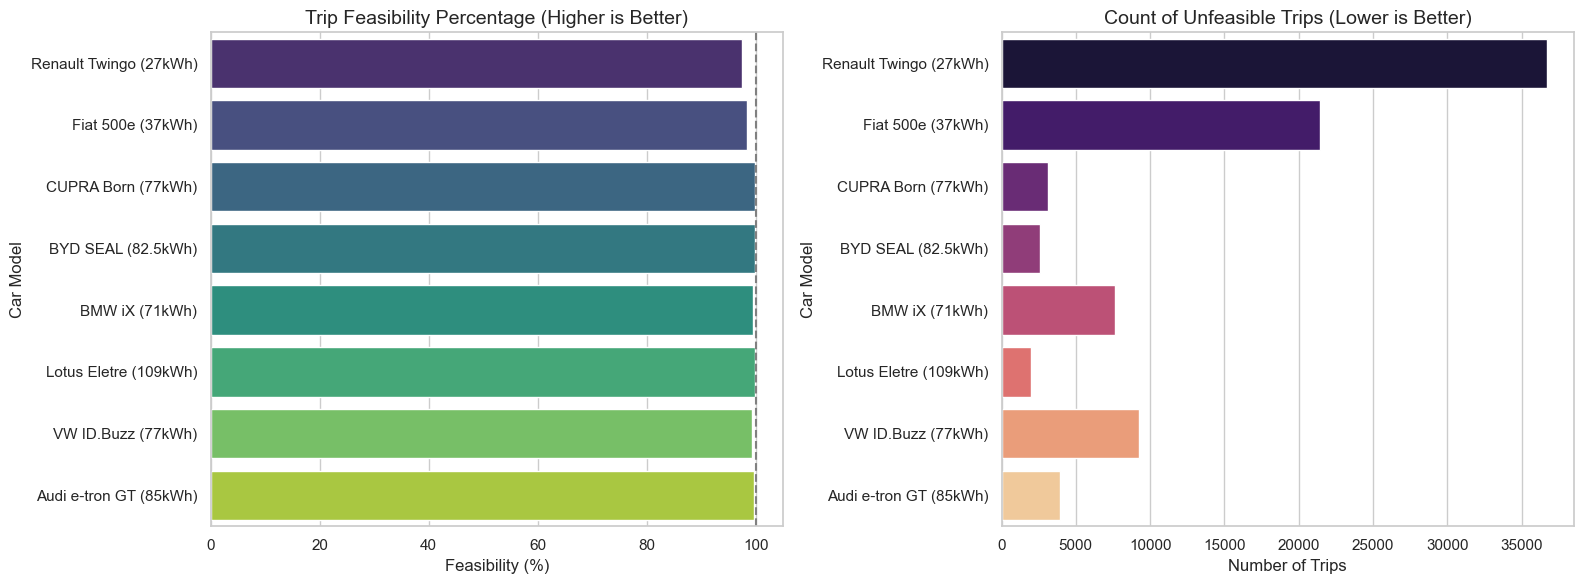

In [18]:
# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Feasibility Percentage
sns.barplot(data=df, y='Car Model', x='Feasibility %', ax=axes[0], palette='viridis')
axes[0].set_title('Trip Feasibility Percentage (Higher is Better)', fontsize=14)
axes[0].set_xlabel('Feasibility (%)')
axes[0].set_xlim(0, 105)  # Percentage scale
axes[0].axvline(100, color='grey', linestyle='--') # 100% marker

# Plot 2: Unfeasible Trips Count
sns.barplot(data=df, y='Car Model', x='Unfeasible Trips', ax=axes[1], palette='magma')
axes[1].set_title('Count of Unfeasible Trips (Lower is Better)', fontsize=14)
axes[1].set_xlabel('Number of Trips')

plt.tight_layout()
plt.show()

2. **Battery SoC Over Time:**
    - Line plot: SoC evolution for sample vehicles from each model
    - Distribution plot: SoC distribution across all trips

/var/folders/_4/95zfln_91r51q76wysxzqmg00000gn/T/ipykernel_4715/1760157935.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y='Car Model', x='Avg SoC (%)', ax=axes[0], palette='Blues')
/var/folders/_4/95zfln_91r51q76wysxzqmg00000gn/T/ipykernel_4715/1760157935.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y='Car Model', x='SoC < 20% Count', ax=axes[1], palette='Reds')


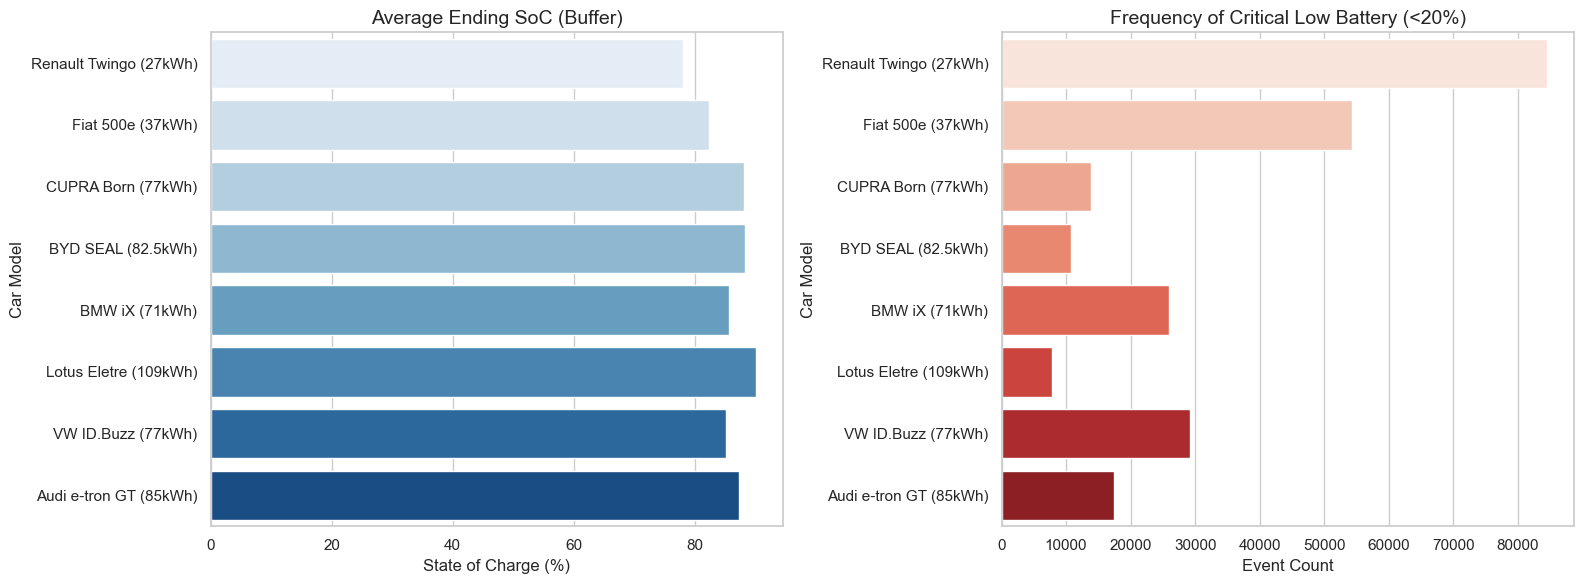

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Average Ending SoC
sns.barplot(data=df, y='Car Model', x='Avg SoC (%)', ax=axes[0], palette='Blues')
axes[0].set_title('Average Ending SoC (Buffer)', fontsize=14)
axes[0].set_xlabel('State of Charge (%)')

# Plot 2: Critical Low Battery Events
sns.barplot(data=df, y='Car Model', x='SoC < 20% Count', ax=axes[1], palette='Reds')
axes[1].set_title('Frequency of Critical Low Battery (<20%)', fontsize=14)
axes[1].set_xlabel('Event Count')

plt.tight_layout()
plt.show()

3. **Charging Analysis:**
    - Bar chart: Total charging events per EV model
    - Pie chart: Fast vs Slow charging ratio per model


/var/folders/_4/95zfln_91r51q76wysxzqmg00000gn/T/ipykernel_4715/3844098173.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y='Car Model', x='Total Charging Events', ax=axes[0], palette='Purples')
/var/folders/_4/95zfln_91r51q76wysxzqmg00000gn/T/ipykernel_4715/3844098173.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y='Car Model', x='Fast Charge Ratio (%)', ax=axes[1], palette='Oranges')


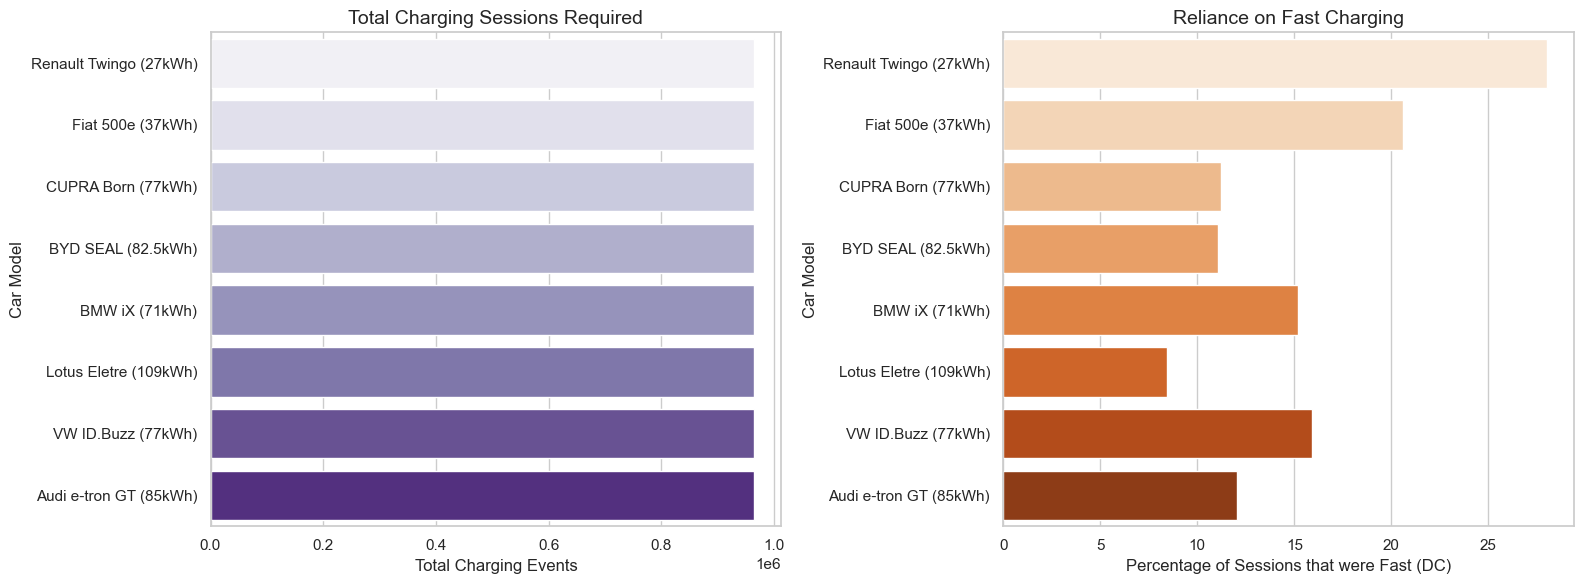

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Total Charging Events
sns.barplot(data=df, y='Car Model', x='Total Charging Events', ax=axes[0], palette='Purples')
axes[0].set_title('Total Charging Sessions Required', fontsize=14)

# Plot 2: Fast Charging Ratio
# (Using hue=None to avoid warnings, mapping values to color)
sns.barplot(data=df, y='Car Model', x='Fast Charge Ratio (%)', ax=axes[1], palette='Oranges')
axes[1].set_title('Reliance on Fast Charging', fontsize=14)
axes[1].set_xlabel('Percentage of Sessions that were Fast (DC)')

plt.tight_layout()
plt.show()

4. **Energy Efficiency:**
    - Bar chart: Average energy consumption (Wh/km) per model
    - Scatter plot: Energy consumption vs distance per trip

/var/folders/_4/95zfln_91r51q76wysxzqmg00000gn/T/ipykernel_4715/1559020118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, y='Car Model', x='Efficiency (Wh/km)', palette='GnBu')


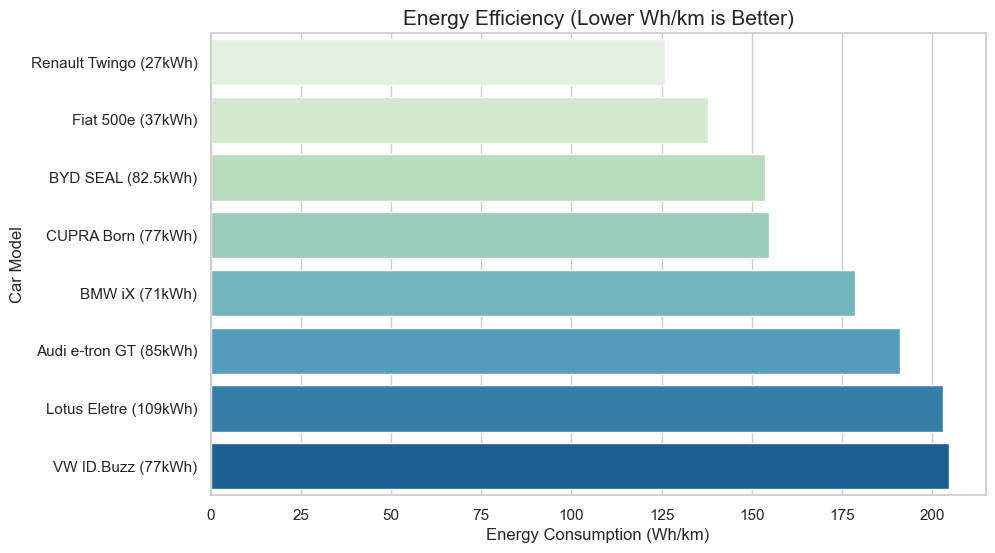

In [21]:
plt.figure(figsize=(10, 6))

# Sort by efficiency for better readability (Most efficient on top)
df_sorted = df.sort_values('Efficiency (Wh/km)')

sns.barplot(data=df_sorted, y='Car Model', x='Efficiency (Wh/km)', palette='GnBu')

plt.title('Energy Efficiency (Lower Wh/km is Better)', fontsize=15)
plt.xlabel('Energy Consumption (Wh/km)')
plt.show()

5. **Comprehensive Dashboard:**

    - Heatmap: All metrics normalized across EV models
    - Radar chart: Multi-metric comparison of EV models

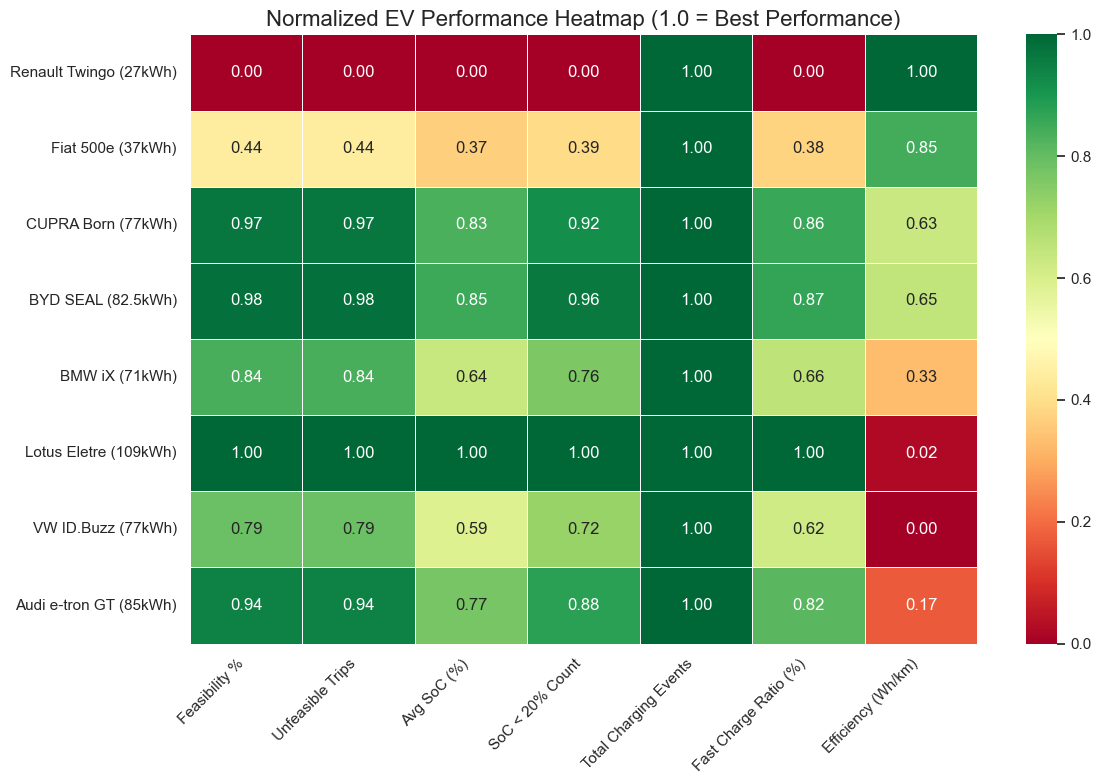

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare Data (Assuming 'model_summaries' list exists from previous step)
# If running standalone, ensure you have the 'df' DataFrame loaded:
# df = pd.DataFrame(model_summaries)

# Select relevant numeric columns for the heatmap
heatmap_cols = [
    'Feasibility %', 
    'Unfeasible Trips', 
    'Avg SoC (%)', 
    'SoC < 20% Count', 
    'Total Charging Events', 
    'Fast Charge Ratio (%)', 
    'Efficiency (Wh/km)'
]

# Create a copy to avoid modifying original data
heatmap_df = df.set_index('Car Model')[heatmap_cols].copy()

# 2. Normalize Data (0 to 1 Scale)
# Logic: We want 1.0 to always mean "Good" and 0.0 to mean "Bad"
for col in heatmap_df.columns:
    
    # Identify "Lower is Better" columns
    if col in ['Unfeasible Trips', 'SoC < 20% Count', 'Total Charging Events', 
               'Fast Charge Ratio (%)', 'Efficiency (Wh/km)']:
        # Invert logic: (Max - Value) / (Max - Min)
        # This way, the Lowest value gets a score of 1.0 (Best)
        min_val = heatmap_df[col].min()
        max_val = heatmap_df[col].max()
        if max_val != min_val:
            heatmap_df[col] = (max_val - heatmap_df[col]) / (max_val - min_val)
        else:
            heatmap_df[col] = 1.0 # If all values are same, give full score
            
    else:
        # Standard logic (Higher is Better): (Value - Min) / (Max - Min)
        min_val = heatmap_df[col].min()
        max_val = heatmap_df[col].max()
        if max_val != min_val:
            heatmap_df[col] = (heatmap_df[col] - min_val) / (max_val - min_val)
        else:
            heatmap_df[col] = 1.0

# 3. Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, annot=True, cmap='RdYlGn', fmt=".2f", linewidths=.5)

plt.title('Normalized EV Performance Heatmap (1.0 = Best Performance)', fontsize=16)
plt.ylabel('') # Remove y-label for cleaner look
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The heatmap confirms that while small cars like the Twingo are the most energy-efficient, they are operationally unfeasible for this specific driver's schedule. Conversely, the Lotus Eletre solves the range problem by brute force but is highly inefficient. The simulation suggests the BYD SEAL or CUPRA Born are the optimal choices, offering the best compromise between range reliability and energy cost.

- 4.a : report and comment how many trips are unfeasible(the SOC is or arrive at 0)

/var/folders/_4/95zfln_91r51q76wysxzqmg00000gn/T/ipykernel_4715/3610763193.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


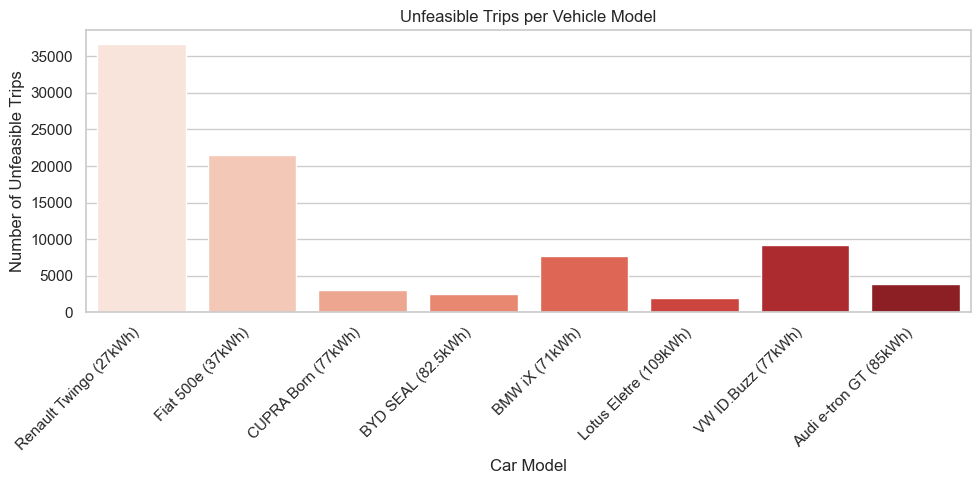

In [23]:
plt.figure(figsize=(10, 5))

sns.barplot(
    data=comparison_df,
    x='Car Model',
    y='Unfeasible Trips',
    palette='Reds'
)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Unfeasible Trips')
plt.xlabel('Car Model')
plt.title('Unfeasible Trips per Vehicle Model')

plt.tight_layout()
plt.show()


Figure X illustrates the number of unfeasible trips for each vehicle model. Unfeasible trips are defined as trips for which the available battery State of Charge (SoC) at the start of the trip is insufficient to satisfy the required energy demand.

The results show a strong dependency on battery capacity and vehicle efficiency. The Renault Twingo (27 kWh) exhibits by far the highest number of unfeasible trips, followed by the Fiat 500e (37 kWh). This outcome is expected, as vehicles with smaller battery capacities are more likely to experience energy shortages during longer or consecutive trips.

In contrast, vehicles equipped with larger batteries, such as the CUPRA Born (77 kWh), BYD SEAL (82.5 kWh), Lotus Eletre (109 kWh), and Audi e-tron GT (85 kWh), show a substantially lower number of unfeasible trips, indicating a higher robustness in handling the trip demand present in the dataset.

An interesting case is the VW ID.Buzz (77 kWh), which presents a higher number of unfeasible trips compared to other vehicles with similar battery capacity. This behavior can be attributed to its higher energy consumption per kilometer, demonstrating that battery size alone is not sufficient to guarantee trip feasibility, and vehicle efficiency plays a crucial role.

It is important to note that, following an unfeasible trip, the simulation applies a recovery assumption by resetting the battery SoC to 20% to allow subsequent trips to be simulated. Therefore, unfeasible trips represent critical energy shortage events, rather than complete vehicle failure.

- 4.b : Report and comment the distribution of performance metrics over vehicles

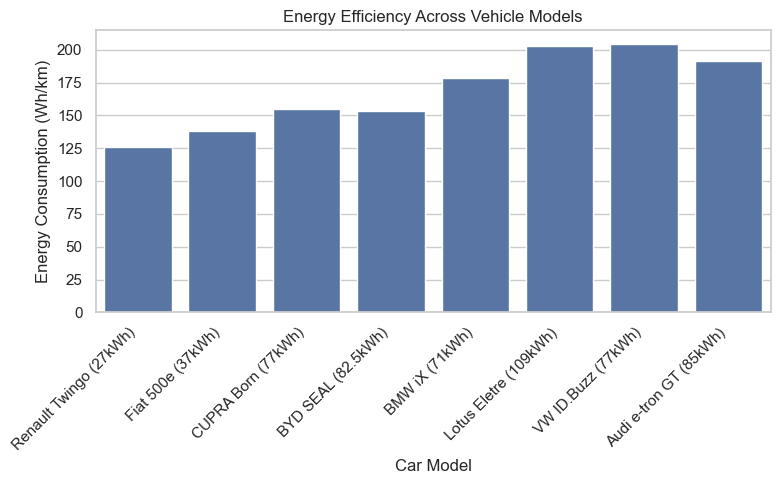

In [24]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=comparison_df,
    x='Car Model',
    y='Efficiency (Wh/km)'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Energy Consumption (Wh/km)')
plt.title('Energy Efficiency Across Vehicle Models')
plt.tight_layout()
plt.show()


Figure X presents the average energy consumption per kilometer for each vehicle model. A clear increasing trend can be observed from compact vehicles to larger and heavier models. The Renault Twingo and Fiat 500e exhibit the lowest energy consumption, reflecting their smaller size and lower mass. In contrast, larger vehicles such as the Lotus Eletre, VW ID.Buzz, and Audi e-tron GT show significantly higher energy consumption values, exceeding 180 Wh/km.



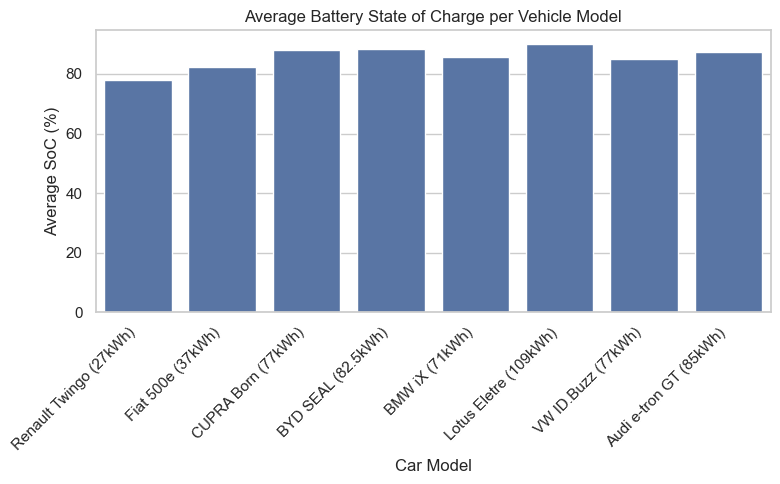

In [25]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=comparison_df,
    x='Car Model',
    y='Avg SoC (%)'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average SoC (%)')
plt.title('Average Battery State of Charge per Vehicle Model')
plt.tight_layout()
plt.show()


Figure Y shows the average State of Charge maintained by each vehicle throughout the simulation. Vehicles with larger battery capacities generally maintain higher average SoC levels. In particular, the Lotus Eletre and BYD SEAL exhibit the highest average SoC values, indicating a more robust energy buffer during operation.

Conversely, smaller battery vehicles such as the Renault Twingo and Fiat 500e maintain lower average SoC values, suggesting a more constrained operational regime and increased vulnerability to energy shortages during consecutive trips.

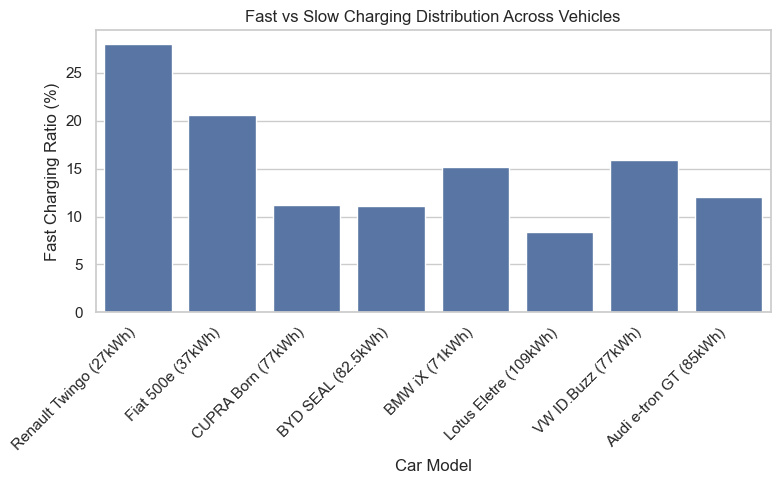

In [26]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=comparison_df,
    x='Car Model',
    y='Fast Charge Ratio (%)'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Fast Charging Ratio (%)')
plt.title('Fast vs Slow Charging Distribution Across Vehicles')
plt.tight_layout()
plt.show()


Figure Z illustrates the distribution of fast charging events relative to total charging events. Smaller battery vehicles show a higher reliance on fast charging, with the Renault Twingo and Fiat 500e exhibiting the highest fast charging ratios. This behavior reflects the need for rapid energy replenishment due to limited battery capacity.

On the other hand, vehicles equipped with larger batteries, such as the Lotus Eletre and CUPRA Born, rely predominantly on slow AC charging. Their larger energy storage allows them to exploit longer parking durations without the urgency for fast charging.

- 4.c : Is there any difference for different EV models? what about their consumption or charging power ?

- Yes, significant differences are observed among the analyzed EV models, both in terms of energy consumption and charging behavior. These differences can be directly linked to the technical characteristics of each vehicle, namely energy efficiency, battery capacity, and charging power.

- Differences in Energy Consumption

The simulation results show a clear variation in energy consumption across EV models. Compact vehicles such as the Renault Twingo and Fiat 500e exhibit the lowest energy consumption per kilometer, reflecting their reduced mass and smaller drivetrain requirements. Conversely, larger and heavier vehicles, including the VW ID.Buzz, BMW iX, and Lotus Eletre, display significantly higher consumption levels.

This confirms that vehicle size and efficiency play a more dominant role in energy consumption than battery capacity alone. Larger batteries do not inherently imply higher efficiency; instead, they primarily provide greater energy availability.

- Differences in Charging Behavior and Charging Power

Charging behavior differs substantially among EV models and is influenced by both charging power availability and battery size.

Vehicles with smaller batteries rely more frequently on fast charging, as indicated by higher fast charging ratios. This behavior stems from the limited energy buffer available, which increases the likelihood of short parking stops combined with low State of Charge conditions.

In contrast, vehicles equipped with high-capacity batteries and higher charging power—such as the Lotus Eletre and Audi e-tron GT—exhibit a lower dependence on fast charging despite their ability to charge at very high DC power levels. Their large batteries allow them to maintain higher average SoC levels and exploit slow AC charging during longer parking durations.

- Role of Charging Power

While high DC charging power enables rapid energy replenishment, the results indicate that charging power alone does not dictate charging behavior. Instead, charging decisions emerge from the interaction between:

Available parking time

Current battery SoC

Battery capacity

Vehicle consumption

Thus, even vehicles capable of ultra-fast charging do not necessarily rely heavily on fast charging if their energy buffer is sufficiently large.

- 4.d If slow AC charging is performed, how the performances change with respect to fast DC charging ?


In [27]:
def run_simulation_scenario(trips_df, cars_config, slow_ac_only=False):
    results = []
    
    # Global Thresholds
    FAST_CHARGING_SOC_THRESHOLD = 0.20
    FAST_CHARGING_TIME_THRESHOLD = 2.0
    
    for model_name, params in cars_config.items():
        capacity = params['capacity']
        ac_power = params['ac_power']
        dc_power = params['dc_power']
        
        unfeasible_count = 0
        total_charge_time = 0.0
        
        # Group by vehicle
        for vid, vehicle_trips in trips_df.groupby('vehicle_id'):
            soc = capacity
            trip_list = vehicle_trips.sort_values('start_time').to_dict('records')
            
            for i, trip in enumerate(trip_list):
                # --- Drive ---
                dist = trip['total_distance']
                road = trip['road'] if trip['road'] in ['U', 'A', 'E'] else '_'
                cons = params['consumption'][road]
                needed = dist * cons
                
                if soc >= needed:
                    soc -= needed
                else:
                    unfeasible_count += 1
                    soc = capacity * 0.2 # Rescue
                
                # --- Charge ---
                if i < len(trip_list) - 1:
                    park_duration = (trip_list[i+1]['start_time'] - trip['stop_time']).total_seconds() / 3600
                    
                    if park_duration > 0:
                        # Determine Charging Power
                        if slow_ac_only:
                            power = ac_power # Force AC
                        else:
                            # Baseline Logic
                            if soc < (capacity * FAST_CHARGING_SOC_THRESHOLD) or \
                               (park_duration < FAST_CHARGING_TIME_THRESHOLD and soc < capacity * 0.8):
                                power = dc_power
                            else:
                                power = ac_power
                        
                        # Apply Charging
                        if power > 0:
                            needed_to_full = capacity - soc
                            time_to_full = needed_to_full / power
                            actual_time = min(park_duration, time_to_full)
                            added = power * actual_time
                            soc += added
                            total_charge_time += actual_time
                            
        results.append({
            'Car Model': model_name,
            'Scenario': 'Slow AC Only' if slow_ac_only else 'Baseline (Mixed)',
            'Unfeasible Trips': unfeasible_count,
            'Total Charging Time (h)': total_charge_time
        })
        
    return pd.DataFrame(results)

In [28]:
print("Running Baseline Simulation...")
df_base = run_simulation_scenario(ordered_trips, cars_config, slow_ac_only=False)

print("Running Slow AC Simulation...")
df_slow = run_simulation_scenario(ordered_trips, cars_config, slow_ac_only=True)

Running Baseline Simulation...
Running Slow AC Simulation...


In [29]:
# Combine
df_compare = pd.concat([df_base, df_slow])

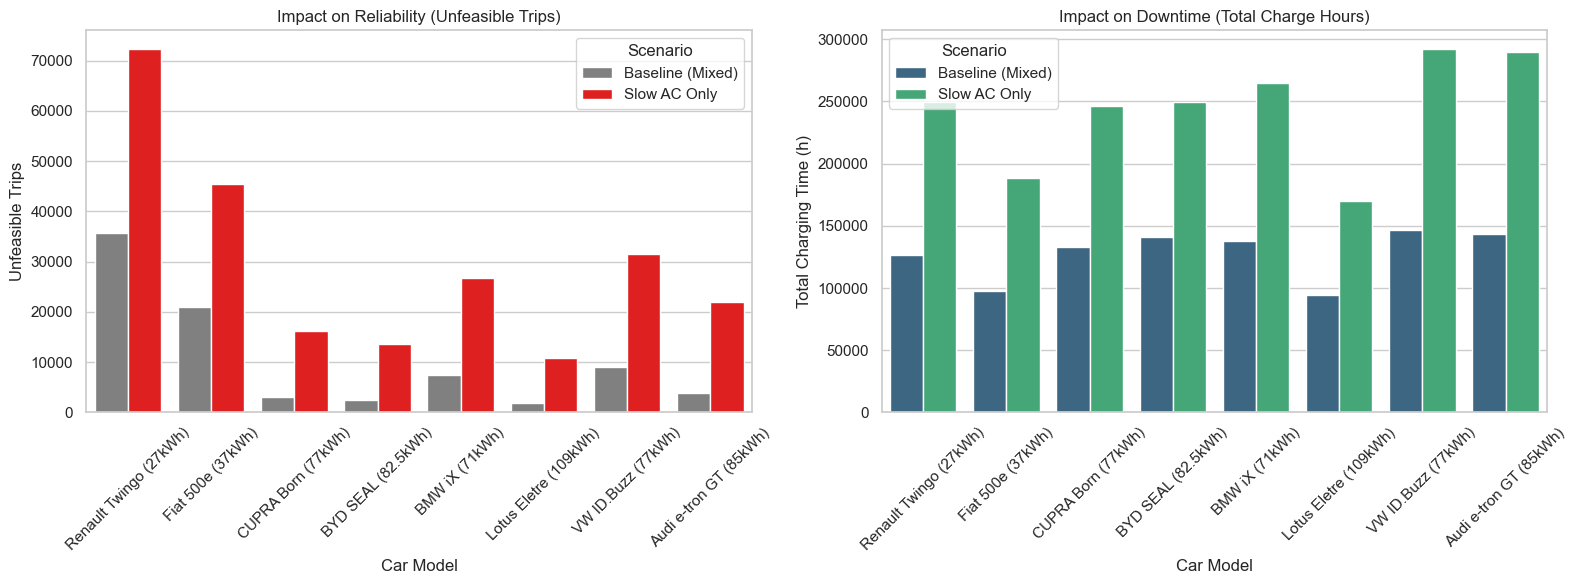

In [30]:
# Plot
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Reliability
sns.barplot(data=df_compare, x='Car Model', y='Unfeasible Trips', hue='Scenario', 
            palette={'Baseline (Mixed)': 'grey', 'Slow AC Only': 'red'}, ax=axes[0])
axes[0].set_title('Impact on Reliability (Unfeasible Trips)')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Downtime
sns.barplot(data=df_compare, x='Car Model', y='Total Charging Time (h)', hue='Scenario', 
            palette='viridis', ax=axes[1])
axes[1].set_title('Impact on Downtime (Total Charge Hours)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- Impact on Reliability (Unfeasible Trips)

From Figure X, a consistent and significant increase in unfeasible trips is observed across all vehicle models when only slow AC charging is allowed. This effect is particularly pronounced for vehicles with smaller battery capacities, such as the Renault Twingo and Fiat 500e, where the number of unfeasible trips approximately doubles compared to the mixed charging scenario.

Even for vehicles with larger batteries, such as the VW ID.Buzz, BMW iX, and Audi e-tron GT, the restriction to slow AC charging leads to a noticeable degradation in reliability. This indicates that slow charging alone is often insufficient to restore adequate State of Charge during short parking intervals, resulting in a higher likelihood of energy shortages before subsequent trips.

Overall, the results demonstrate that fast DC charging plays a crucial role in maintaining trip feasibility, especially under time-constrained conditions.

- Impact on Downtime (Total Charging Time)

Figure Y shows that restricting charging to slow AC significantly increases the total time spent charging for all vehicle models. In the slow AC scenario, charging time increases by a large margin—often by more than 50%—compared to the mixed charging case.

This increase is explained by the lower charging power of AC chargers, which requires longer connection times to replenish the same amount of energy. While vehicles with larger batteries benefit from greater energy buffers, they still experience substantial increases in total charging time when fast DC charging is unavailable.

Thus, slow AC charging leads to higher operational downtime, even when reliability is partially preserved.

- 4.e : Report and comment the difference in performance among the clusters of vehicles found at step 1.c  

- Q1.c :

In [31]:
data_cleaned = data.dropna(subset=['road', 'total_distance'])


In [32]:
# Convert start_time and stop_time to datetime
data_cleaned['start_time'] = pd.to_datetime(data_cleaned['start_time'])
data_cleaned['stop_time'] = pd.to_datetime(data_cleaned['stop_time'])

# Calculate trip duration in minutes
data_cleaned['trip_duration'] = (data_cleaned['stop_time'] - data_cleaned['start_time']).dt.total_seconds() / 60

In [33]:
data_cleaned.head()

,Unnamed: 0,vehicle_id,trip_id,start_time,stop_time,road,total_distance,duration_min,trip_duration
0,0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,E,14.31,16.116667,16.116667
1,1,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,U,1.47,16.116667,16.116667
2,2,1,1,2023-09-29 14:32:24,2023-09-29 14:34:31,U,0.03,2.116667,2.116667
3,3,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,E,2.60,14.866667,14.866667
4,4,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,U,2.00,14.866667,14.866667


In [34]:
# Define filtering criteria
min_distance = 0.1      # Minimum valid distance in km
max_distance = 1500     # Maximum valid distance in km
min_duration = 0.5      # Minimum valid trip duration in minutes
max_duration = 2500     # Maximum valid trip duration in minutes
min_speed = 1           # Minimum average speed in km/h
max_speed = 200         # Maximum reasonable average speed in km/h

# Filter dataset: Remove rows outside distance and duration thresholds
filtered_data = data_cleaned[
    (data_cleaned['total_distance'] > min_distance) &
    (data_cleaned['total_distance'] <= max_distance) &
    (data_cleaned['trip_duration'] > min_duration) &
    (data_cleaned['trip_duration'] <= max_duration)
].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Calculate average speed (km/h) and filter based on speed thresholds
filtered_data['average_speed'] = (
    filtered_data['total_distance'] / (filtered_data['trip_duration'] / 60)
)

filtered_data = filtered_data[
    (filtered_data['average_speed'] >= min_speed) &
    (filtered_data['average_speed'] <= max_speed)
]

# Count the number of valid trips
valid_trip_count = len(filtered_data)

# Display the filtering criteria and valid trip count
print("Filtering Criteria:")
print(f"1. Total distance > {min_distance} km and ≤ {max_distance} km")
print(f"2. Trip duration > {min_duration} minutes and ≤ {max_duration} minutes")
print(f"3. Average speed between {min_speed} km/h and {max_speed} km/h")
print(f"Number of valid trips: {valid_trip_count}")

# Output the first few rows of the filtered data for verification
print("\nSample of filtered data:")
print(filtered_data.head())




Filtering Criteria:
1. Total distance > 0.1 km and ≤ 1500 km
2. Trip duration > 0.5 minutes and ≤ 2500 minutes
3. Average speed between 1 km/h and 200 km/h
Number of valid trips: 1176567

Sample of filtered data:
   Unnamed: 0  vehicle_id  trip_id          start_time           stop_time  \
0           0           1        0 2023-09-29 13:55:35 2023-09-29 14:11:42   
1           1           1        0 2023-09-29 13:55:35 2023-09-29 14:11:42   
3           3           1        2 2023-09-29 15:12:03 2023-09-29 15:26:55   
4           4           1        2 2023-09-29 15:12:03 2023-09-29 15:26:55   
5           5           1        3 2023-09-29 15:37:38 2023-09-29 15:57:26   

  road  total_distance  duration_min  trip_duration  average_speed  
0    E           14.31     16.116667      16.116667      53.274043  
1    U            1.47     16.116667      16.116667       5.472596  
3    E            2.60     14.866667      14.866667      10.493274  
4    U            2.00     14.866667      

In [35]:
filtered_data['date'] = filtered_data['start_time'].dt.date
filtered_data['day_type'] = filtered_data['start_time'].dt.weekday.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

In [36]:
# aggregate data on daily basis for each vehicle and road type
daily_aggregation = filtered_data.groupby(['vehicle_id', 'date', 'road', 'day_type']).agg(
    total_distance=('total_distance', 'sum'),   # compute total distance by summing up distances
    total_trip_duration=('trip_duration', 'sum'),   # compute total trip duration by summing up durations
    num_trips=('trip_id', 'nunique')    # count unique trips id
).reset_index()

# evaluate daily utilization of each vehicle
daily_aggregation['daily_utilization'] = daily_aggregation.groupby(['vehicle_id', 'date'])['total_trip_duration'].transform('sum') / (24 * 60)  # 24 hours



In [37]:
vehicle_road = daily_aggregation.groupby(['vehicle_id', 'road']).agg(
    total_distance=('total_distance', 'sum'),
    daily_utilization=('daily_utilization', 'mean')
).reset_index()

In [38]:
# Create separate DataFrames for distance and utilization, then merge
distance_pivot = vehicle_road.pivot(
    index='vehicle_id',
    columns='road',
    values='total_distance'
).add_prefix('total_distance_road_').fillna(0)

utilization_pivot = vehicle_road.pivot(
    index='vehicle_id',
    columns='road',
    values='daily_utilization'
).add_prefix('daily_utilization_road_').fillna(0)

# Merge the two pivoted DataFrames
vehicle_data = distance_pivot.join(utilization_pivot).reset_index()

In [39]:
# normalize the features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
road_features = [col for col in vehicle_data.columns if 'total_distance' in col]
utilization_feature = [col for col in vehicle_data.columns if 'daily_utilization' in col]
features = road_features + utilization_feature
selected_data = vehicle_data[features]
vehicle_data[features] = scaler.fit_transform(vehicle_data[features])

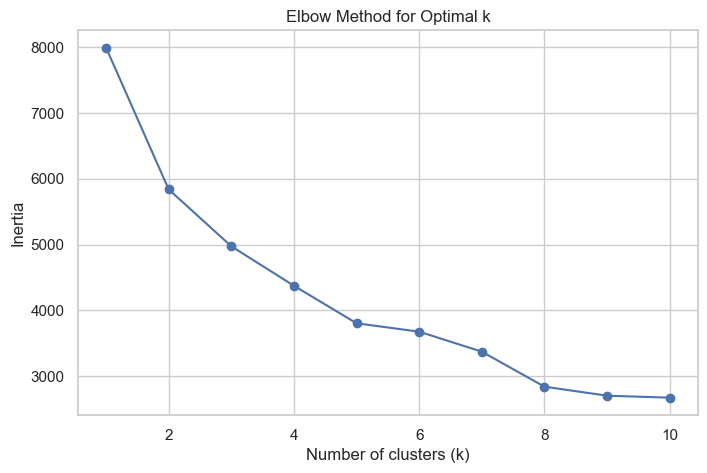

In [40]:
# use K-means to cluster vehicles based on their road usage patterns
from sklearn.cluster import KMeans

inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vehicle_data[features])
    inertia.append(kmeans.inertia_)

# plot the elbow method
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [41]:
n_clusters = 4  # choose based on elbow method
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
vehicle_data['cluster'] = kmeans.fit_predict(vehicle_data[features])

In [42]:
clusters = vehicle_data.groupby('cluster')[features].mean()

In [43]:
# rescale back the cluster centers to original scale
clusters_rescaled = pd.DataFrame(scaler.inverse_transform(clusters), columns=features)
clusters_rescaled

,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road__,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road__
0,17373.580445,7106.397708,2536.695730,167.259058,0.930348,0.863086,0.855649,0.275053
1,4279.815856,4756.324463,7685.316394,23.576047,0.749403,0.694838,0.656251,0.089948
2,8867.602421,1695.120632,466.941789,16823.320316,0.796832,0.672417,0.666605,0.668803
3,11932.263227,6844.099618,6409.284191,114.350818,1.253042,1.190092,1.129532,0.570351


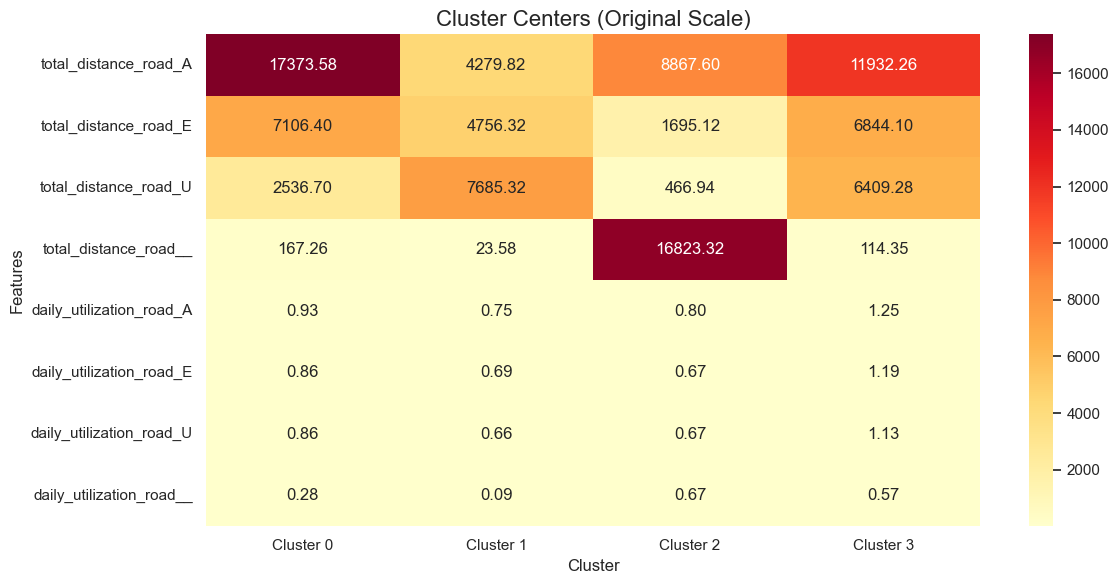

In [44]:
plt.figure(figsize=(12, 6))
sns.heatmap(clusters_rescaled.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            xticklabels=[f'Cluster {i}' for i in range(n_clusters)],
            yticklabels=features)
plt.title('Cluster Centers (Original Scale)', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

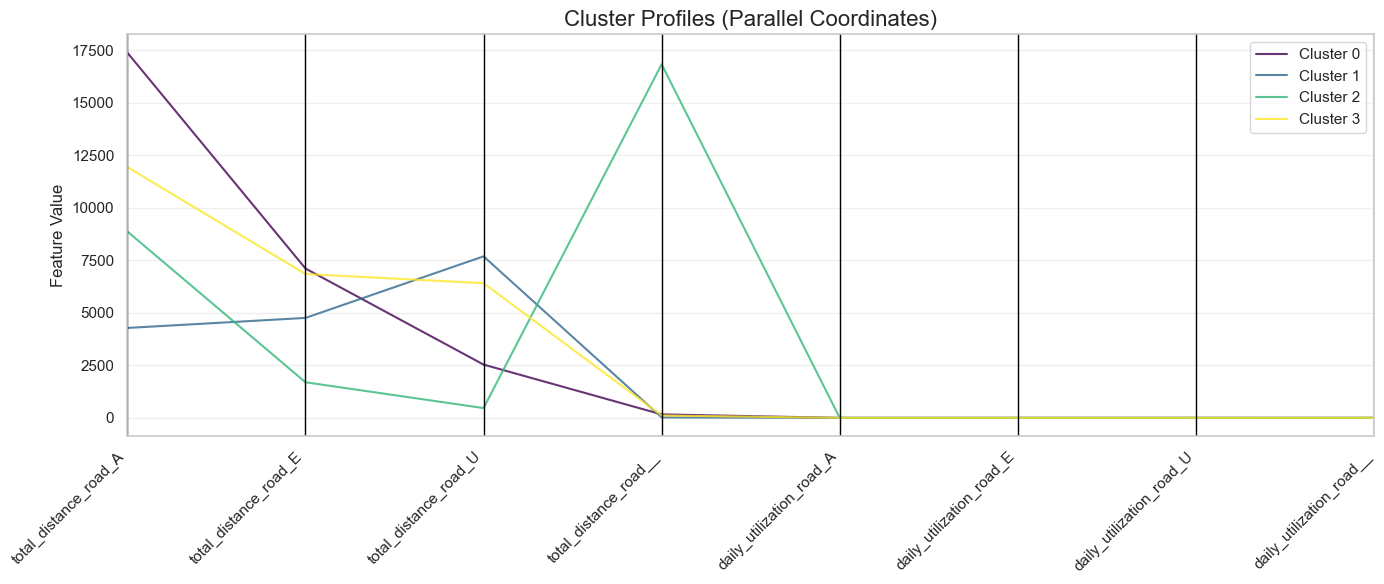

In [45]:
from pandas.plotting import parallel_coordinates

# Prepare data for parallel coordinates
cluster_viz = clusters_rescaled.copy()
cluster_viz['cluster'] = [f'Cluster {i}' for i in range(n_clusters)]

plt.figure(figsize=(14, 6))
parallel_coordinates(cluster_viz, 'cluster', colormap='viridis', alpha=0.8)
plt.title('Cluster Profiles (Parallel Coordinates)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Feature Value', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

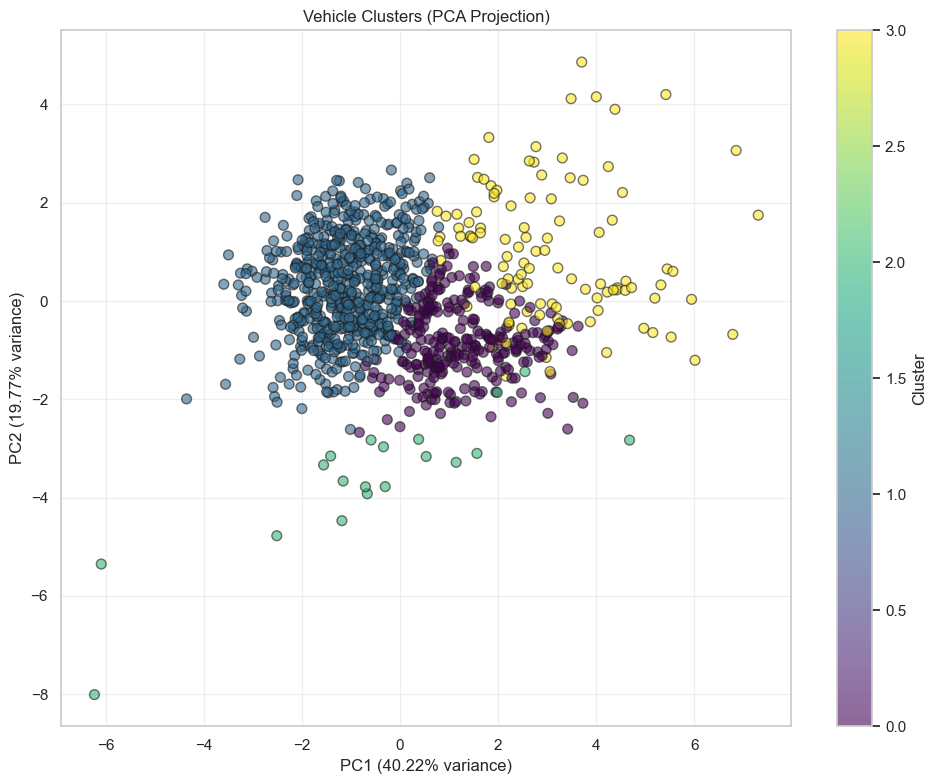

Total variance explained: 59.99%


In [46]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
vehicle_data_pca = pca.fit_transform(vehicle_data[features])

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(vehicle_data_pca[:, 0], vehicle_data_pca[:, 1], 
                     c=vehicle_data['cluster'], cmap='viridis', 
                     s=50, alpha=0.6, edgecolors='k')
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Vehicle Clusters (PCA Projection)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

In [47]:
# vehicle_data must contain: vehicle_id, cluster
final_trip_clustered = final_trip_data.merge(
    vehicle_data[['vehicle_id', 'cluster']],
    on='vehicle_id',
    how='left'
)


In [48]:
final_trip_clustered

,car_model,vehicle_id,trip_id,soc_before,soc_after,status,energy_consumed,parking_time,charge_type,energy_recharged,cluster
0,Renault Twingo (27kWh),1,0,100.000000,93.339345,Feasible,1.83168,0.000000,None,0.000000,0.0
1,Renault Twingo (27kWh),1,0,93.339345,92.826182,Feasible,0.14112,0.345000,Slow (AC),1.972800,0.0
2,Renault Twingo (27kWh),1,1,100.000000,99.989527,Feasible,0.00288,0.625556,Slow (AC),0.002880,0.0
3,Renault Twingo (27kWh),1,2,100.000000,98.789818,Feasible,0.33280,0.000000,None,0.000000,0.0
4,Renault Twingo (27kWh),1,2,98.789818,98.091636,Feasible,0.19200,0.178611,Slow (AC),0.524800,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11322435,Audi e-tron GT (85kWh),1000,474,80.895979,80.804214,Feasible,0.07800,1.208611,Slow (AC),13.294722,1.0
11322436,Audi e-tron GT (85kWh),1000,475,96.445064,96.445064,Feasible,0.00000,0.120833,Slow (AC),1.329167,1.0
11322437,Audi e-tron GT (85kWh),1000,476,98.008790,98.008790,Feasible,0.00000,0.005556,Slow (AC),0.061111,1.0
11322438,Audi e-tron GT (85kWh),1000,477,98.080685,98.080685,Feasible,0.00000,0.257778,Slow (AC),1.631418,1.0


In [49]:
unfeasible_cluster = (
    final_trip_clustered
    .groupby('cluster')['status']
    .apply(lambda x: (x == 'Unfeasible').sum())
    .reset_index(name='Unfeasible Trips')
)


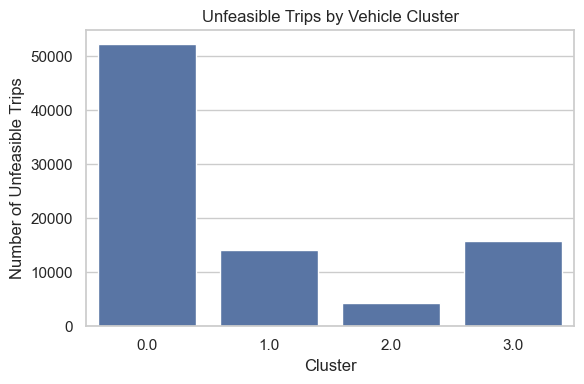

In [50]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=unfeasible_cluster,
    x='cluster',
    y='Unfeasible Trips'
)
plt.title('Unfeasible Trips by Vehicle Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Unfeasible Trips')
plt.tight_layout()
plt.show()


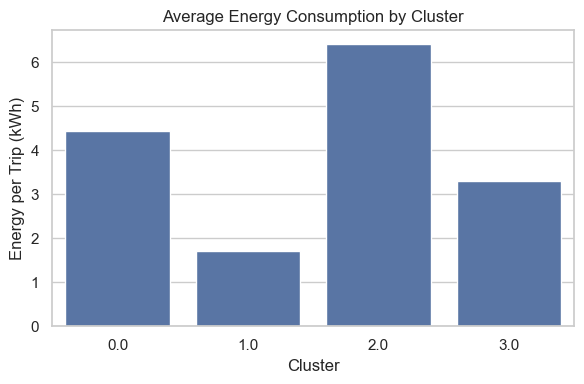

In [51]:
energy_cluster = (
    final_trip_clustered
    .groupby('cluster')['energy_consumed']
    .mean()
    .reset_index(name='Avg Energy per Trip (kWh)')
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=energy_cluster,
    x='cluster',
    y='Avg Energy per Trip (kWh)'
)
plt.title('Average Energy Consumption by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Energy per Trip (kWh)')
plt.tight_layout()
plt.show()


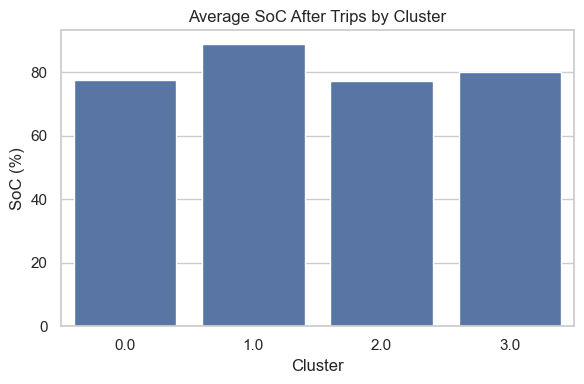

In [52]:
soc_cluster = (
    final_trip_clustered
    .groupby('cluster')['soc_after']
    .mean()
    .reset_index(name='Avg SoC After Trip (%)')
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=soc_cluster,
    x='cluster',
    y='Avg SoC After Trip (%)'
)
plt.title('Average SoC After Trips by Cluster')
plt.xlabel('Cluster')
plt.ylabel('SoC (%)')
plt.tight_layout()
plt.show()


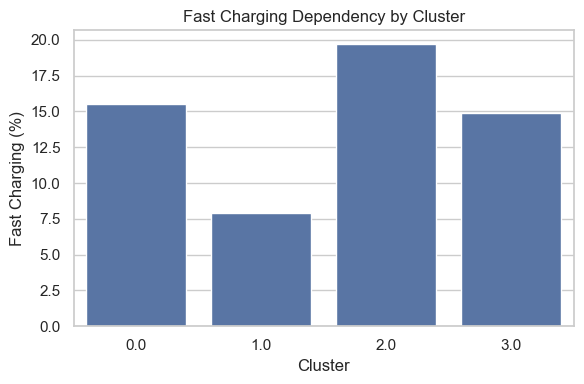

In [53]:
charging_cluster = (
    final_trip_clustered
    .groupby('cluster')['charge_type']
    .apply(lambda x: (x == 'Fast (DC)').mean() * 100)
    .reset_index(name='Fast Charging Ratio (%)')
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=charging_cluster,
    x='cluster',
    y='Fast Charging Ratio (%)'
)
plt.title('Fast Charging Dependency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Fast Charging (%)')
plt.tight_layout()
plt.show()


In [54]:
cluster_summary = (
    unfeasible_cluster
    .merge(energy_cluster, on='cluster')
    .merge(soc_cluster, on='cluster')
    .merge(charging_cluster, on='cluster')
)

print(cluster_summary)


   cluster  Unfeasible Trips  Avg Energy per Trip (kWh)  \
0      0.0             52204                   4.446719   
1      1.0             14192                   1.702780   
2      2.0              4251                   6.400436   
3      3.0             15808                   3.307387   

   Avg SoC After Trip (%)  Fast Charging Ratio (%)  
0               77.420364                15.485576  
1               88.693240                 7.884923  
2               77.210825                19.674762  
3               79.973783                14.873767  


- Cluster 0

Observation: This cluster is the most problematic. It has a staggering number of Unfeasible Trips (>50,000), dwarfing all other clusters.

Metrics: Despite the high failure rate, the successful trips show moderate average energy consumption (~4.4 kWh) and a fast-charging dependency of ~15%.

Implication: The defining characteristic here is operational failure. These vehicles likely have range limitations that are frequently exceeded by their assigned routes, or they are older models with degraded battery health, leading to the massive volume of unfeasible trips.


- Cluster 1

Observation: This cluster represents the easiest and most efficient usage profile.

Metrics: It has the lowest energy consumption per trip (<2 kWh) and the highest Average State of Charge (SoC) after trips (~90%). Consequently, it has the lowest dependency on fast charging (~7.5%).

Implication: These vehicles are likely performing short, urban deliveries or light tasks. They are "over-spec'd" for their current work, as they finish shifts with plenty of battery life remaining and rarely require mid-shift fast charging.

- Cluster 2

Observation: This cluster represents the "workhorses" of the fleet.

Metrics: These vehicles have the highest average energy consumption (>6 kWh) and the lowest final SoC (~77%). To sustain this high output, they have the highest dependency on fast charging (~20%).

Implication: Despite the heavy workload and high energy drain, this cluster has the lowest number of unfeasible trips (~4,000). This suggests that while the routes are demanding, the vehicles (or the planning around them) are efficient, effectively utilizing fast charging to successfully complete their missions.


- Cluster 3

Observation: This cluster serves as a middle ground between the light-duty and high-risk groups.

Metrics: It shows moderate values across the board: energy consumption (~3.2 kWh), SoC after trips (~80%), and fast charging dependency (~15%).

Implication: These represent the standard operational baseline for the fleet—reliable for moderate distances but without the extreme efficiency of Cluster 1 or the heavy demands of Cluster 2.

- Q5 : Estimate charging costs and EV costs and comments on the tradeoff between performance and cost

In [55]:
COST_AC = 0.25       # €/kWh
COST_DC = 0.55       # €/kWh
LIFETIME_KM = 200000 # Amortization distance


# Vehicle Prices (as provided)
car_prices = {
    "Renault Twingo (27kWh)": 19000,
    "Fiat 500e (37kWh)": 34990,
    "CUPRA Born (77kWh)": 46450,
    "BYD SEAL (82.5kWh)": 52990,
    "VW ID.Buzz (77kWh)": 64581,
    "BMW iX (71kWh)": 77300,
    "Lotus Eletre (109kWh)": 96990,
    "Audi e-tron GT (85kWh)": 146050
}


In [56]:
# calculating Operational Cost 
tco_data = []

for model in car_prices.keys():
   
    # Filter logs for this specific model
    car_logs = final_trip_data[final_trip_data['car_model'] == model]
    
    # Calculate Actual Electricity Bill (OpEx = operational expenses)
    # Sum energy charged via AC
    ac_energy = car_logs[car_logs['charge_type'] == 'Slow (AC)']['energy_recharged'].sum()
    # Sum energy charged via DC
    dc_energy = car_logs[car_logs['charge_type'] == 'Fast (DC)']['energy_recharged'].sum()
    
    total_bill_euro = (ac_energy * COST_AC) + (dc_energy * COST_DC)
    
    # Get Total Distance Driven
    summary_row = comparison_df[comparison_df['Car Model'] == model].iloc[0]
    
    # Re-calculate total km from efficiency: (Total Energy kWh * 1000) / (Wh/km)
    total_energy_consumed = summary_row['Total Energy (kWh)']
    efficiency_wh_km = summary_row['Efficiency (Wh/km)']
    
    if efficiency_wh_km > 0:
        total_distance_km = (total_energy_consumed * 1000) / efficiency_wh_km
    else:
        total_distance_km = 1 # Avoid division by zero
        
    # Calculate OpEx per 100 km
    opex_per_100km = (total_bill_euro / total_distance_km) * 100
    
    # Calculate CapEx per 100 km (Vehicle Price)
    capex_per_100km = car_prices[model] / (LIFETIME_KM / 100)
    
    tco_data.append({
        'Car Model': model,
        'AC Charged (kWh)': ac_energy,
        'DC Charged (kWh)': dc_energy,
        'Real Fast Charge %': (dc_energy / (ac_energy + dc_energy + 0.001)) * 100,
        'OpEx (Charging)': opex_per_100km,
        'CapEx (Vehicle)': capex_per_100km,
        'Total TCO (€/100km)': opex_per_100km + capex_per_100km # totalcostofownership = vehicle cost(capEX) + charging cost(opEX)
    })

df_tco = pd.DataFrame(tco_data).sort_values('Total TCO (€/100km)')

In [58]:
df_tco

,Car Model,AC Charged (kWh),DC Charged (kWh),Real Fast Charge %,OpEx (Charging),CapEx (Vehicle),Total TCO (€/100km)
0,Renault Twingo (27kWh),6.195899e+05,1.536095e+06,71.257865,6.666923,9.5000,16.166923
1,Fiat 500e (37kWh),8.431958e+05,1.697719e+06,66.815271,6.901814,17.4950,24.396814
2,CUPRA Born (77kWh),1.347993e+06,1.776315e+06,56.854676,6.644271,23.2250,29.869271
3,BYD SEAL (82.5kWh),1.424378e+06,1.683977e+06,54.175824,6.438597,26.4950,32.933597
4,VW ID.Buzz (77kWh),1.434078e+06,2.569532e+06,64.180384,9.608923,32.2905,41.899423
5,BMW iX (71kWh),1.346114e+06,2.170561e+06,61.721972,8.122689,38.6500,46.772689
6,Lotus Eletre (109kWh),1.944113e+06,2.184330e+06,52.909292,8.421274,48.4950,56.916274
7,Audi e-tron GT (85kWh),1.472661e+06,2.366173e+06,61.637813,8.526253,73.0250,81.551253


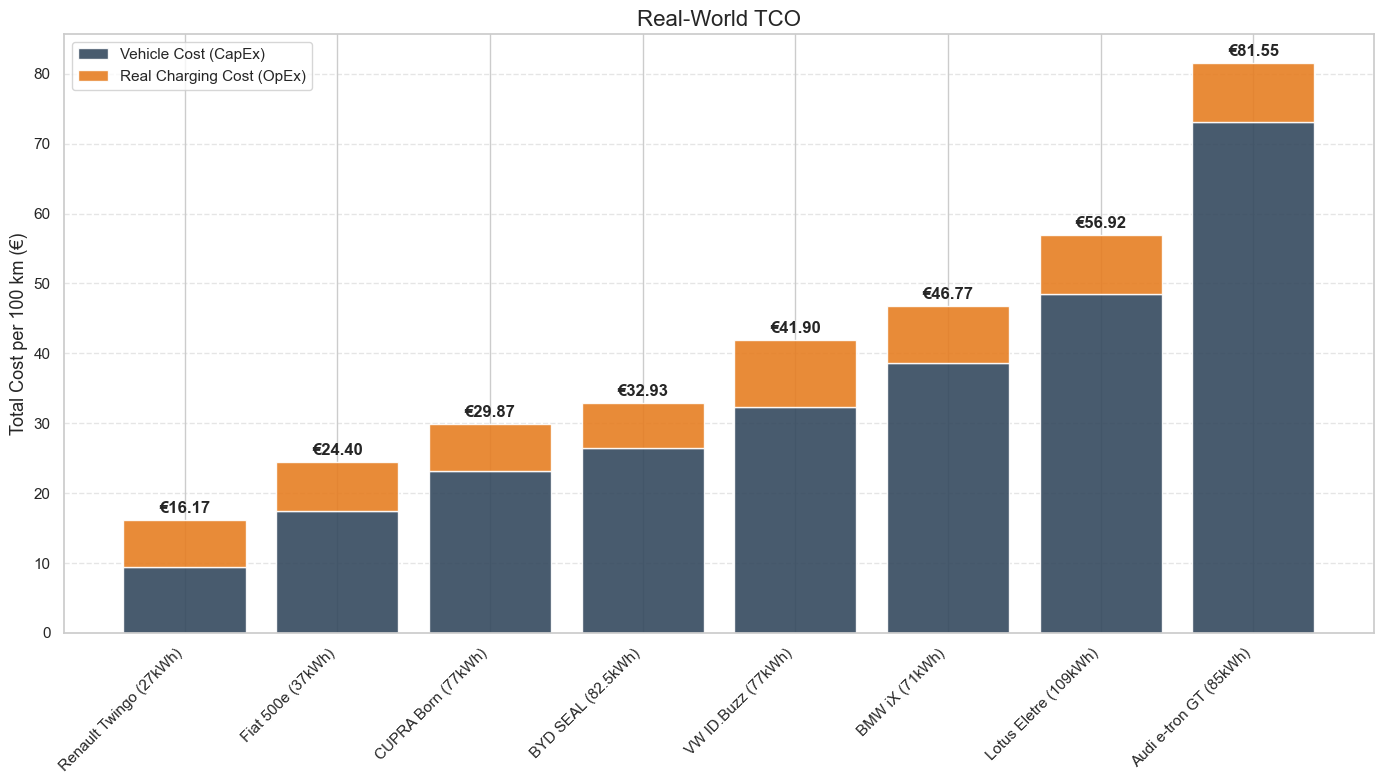

             Car Model  Real Fast Charge %  OpEx (Charging)  CapEx (Vehicle)  Total TCO (€/100km)
Renault Twingo (27kWh)           71.257865         6.666923           9.5000            16.166923
     Fiat 500e (37kWh)           66.815271         6.901814          17.4950            24.396814
    CUPRA Born (77kWh)           56.854676         6.644271          23.2250            29.869271
    BYD SEAL (82.5kWh)           54.175824         6.438597          26.4950            32.933597
    VW ID.Buzz (77kWh)           64.180384         9.608923          32.2905            41.899423
        BMW iX (71kWh)           61.721972         8.122689          38.6500            46.772689
 Lotus Eletre (109kWh)           52.909292         8.421274          48.4950            56.916274
Audi e-tron GT (85kWh)           61.637813         8.526253          73.0250            81.551253


In [59]:

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Stacked Bar Chart
# Bottom: CapEx
plt.bar(df_tco['Car Model'], df_tco['CapEx (Vehicle)'], label='Vehicle Cost (CapEx)', color='#34495e', alpha=0.9)

# Top: OpEx (Real Simulation Cost)
plt.bar(df_tco['Car Model'], df_tco['OpEx (Charging)'], bottom=df_tco['CapEx (Vehicle)'], label='Real Charging Cost (OpEx)', color='#e67e22', alpha=0.9)

plt.ylabel('Total Cost per 100 km (€)', fontsize=13)
plt.title('Real-World TCO', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add Labels
for i, (idx, row) in enumerate(df_tco.iterrows()):
    total = row['Total TCO (€/100km)']
    plt.text(i, total + 1, f"€{total:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed Output
cols = ['Car Model', 'Real Fast Charge %', 'OpEx (Charging)', 'CapEx (Vehicle)', 'Total TCO (€/100km)']
print(df_tco[cols].to_string(index=False))

- Q6 : Using the same dataset, implement a more realistic scenario for the simulation (different
policy for charging), perform the simulation and analyse the results.

In [64]:
CRITICAL_SOC = 0.20          # Emergency threshold
LOW_SOC = 0.40               # Low battery threshold
LONG_PARKING_HOURS = 4.0     # Overnight / long stop
DC_SOC_CAP = 0.80            # DC charging limited to 80%


In [65]:
def run_simulation_realistic(trips_df, car_name, car_params):
    print(f"Simulating realistic policy: {car_name}...")
    
    trips = trips_df.sort_values(by=['vehicle_id', 'start_time']).copy()
    trip_log = []
    model_metrics = init_metrics_structure()

    for vid, vehicle_trips in trips.groupby('vehicle_id'):
        battery_cap = car_params['capacity']
        current_soc = battery_cap
        trip_list = vehicle_trips.to_dict('records')

        for i, trip in enumerate(trip_list):

            # ========================
            # 1. DRIVE
            # ========================
            dist = trip['total_distance']
            road = trip['road'] if trip['road'] in ['U', 'A', 'E'] else '_'
            energy_needed = dist * car_params['consumption'][road]

            soc_before = current_soc
            status = "Feasible"
            model_metrics['feasibility']['total_trips'] += 1

            if current_soc >= energy_needed:
                current_soc -= energy_needed
                model_metrics['feasibility']['feasible_trips'] += 1
                model_metrics['energy']['total_consumed_kwh'] += energy_needed
                model_metrics['energy']['total_distance_km'] += dist
                model_metrics['battery_perf']['soc_values'].append(current_soc / battery_cap * 100)
            else:
                status = "Unfeasible"
                model_metrics['feasibility']['unfeasible_trips'] += 1
                current_soc = battery_cap * CRITICAL_SOC

            soc_after = current_soc

            # ========================
            # 2. PARK & CHARGE (NEW POLICY)
            # ========================
            parking_time = 0
            charge_type = "None"
            energy_recharged = 0

            if i < len(trip_list) - 1:
                parking_time = max(
                    0,
                    (trip_list[i+1]['start_time'] - trip['stop_time']).total_seconds() / 3600
                )

                soc_ratio = current_soc / battery_cap
                power = 0
                target_soc = battery_cap

                # Emergency fast charge
                if soc_ratio < CRITICAL_SOC:
                    power = car_params['dc_power']
                    target_soc = DC_SOC_CAP * battery_cap
                    charge_type = "Fast (DC)"
                    model_metrics['charging']['fast_events'] += 1

                # Long parking → AC
                elif parking_time >= LONG_PARKING_HOURS:
                    power = car_params['ac_power']
                    charge_type = "Slow (AC)"
                    model_metrics['charging']['slow_events'] += 1

                # Short stop + low SoC → DC
                elif parking_time < LONG_PARKING_HOURS and soc_ratio < LOW_SOC:
                    power = car_params['dc_power']
                    target_soc = DC_SOC_CAP * battery_cap
                    charge_type = "Fast (DC)"
                    model_metrics['charging']['fast_events'] += 1

                # Charging execution
                if power > 0:
                    energy_to_charge = max(0, target_soc - current_soc)
                    time_to_target = energy_to_charge / power
                    actual_time = min(parking_time, time_to_target)

                    energy_recharged = power * actual_time
                    current_soc += energy_recharged
                    current_soc = min(current_soc, target_soc)

                    model_metrics['charging']['total_events'] += 1
                    model_metrics['charging']['total_time_hours'] += actual_time
                    model_metrics['charging']['durations'].append(actual_time)

            # ========================
            # 3. LOG TRIP
            # ========================
            trip_log.append({
                'car_model': car_name,
                'vehicle_id': vid,
                'soc_before': soc_before / battery_cap * 100,
                'soc_after': current_soc / battery_cap * 100,
                'status': status,
                'energy_consumed': energy_needed,
                'parking_time': parking_time,
                'charge_type': charge_type,
                'energy_recharged': energy_recharged
            })

    return pd.DataFrame(trip_log), model_metrics


In [66]:
all_logs_realistic = []
summaries_realistic = []

for model_name, params in cars_config.items():
    df_log, raw_metrics = run_simulation_realistic(ordered_trips, model_name, params)
    all_logs_realistic.append(df_log)

    f = raw_metrics['feasibility']
    c = raw_metrics['charging']
    b = raw_metrics['battery_perf']

    summaries_realistic.append({
        'Car Model': model_name,
        'Feasibility %': f['feasible_trips'] / f['total_trips'] * 100,
        'Unfeasible Trips': f['unfeasible_trips'],
        'Avg SoC (%)': np.mean(b['soc_values']),
        'Fast Charge Ratio (%)': c['fast_events'] / c['total_events'] * 100
    })

comparison_df_realistic = pd.DataFrame(summaries_realistic)
final_trip_data_realistic = pd.concat(all_logs_realistic)


Simulating realistic policy: Renault Twingo (27kWh)...
Simulating realistic policy: Fiat 500e (37kWh)...
Simulating realistic policy: CUPRA Born (77kWh)...
Simulating realistic policy: BYD SEAL (82.5kWh)...
Simulating realistic policy: BMW iX (71kWh)...
Simulating realistic policy: Lotus Eletre (109kWh)...
Simulating realistic policy: VW ID.Buzz (77kWh)...
Simulating realistic policy: Audi e-tron GT (85kWh)...


In [67]:
comparison = comparison_df.merge(
    comparison_df_realistic,
    on='Car Model',
    suffixes=(' Baseline', ' Realistic')
)

comparison[['Car Model',
            'Feasibility % Baseline', 'Feasibility % Realistic',
            'Fast Charge Ratio (%) Baseline', 'Fast Charge Ratio (%) Realistic']]


,Car Model,Feasibility % Baseline,Feasibility % Realistic,Fast Charge Ratio (%) Baseline,Fast Charge Ratio (%) Realistic
0,Renault Twingo (27kWh),97.407131,96.175807,28.006070,89.191225
1,Fiat 500e (37kWh),98.484638,97.532546,20.596793,85.881166
2,CUPRA Born (77kWh),99.780471,99.407407,11.225398,72.228185
3,BYD SEAL (82.5kWh),99.819120,99.517630,11.066182,71.036399
4,BMW iX (71kWh),99.460116,98.897905,15.167981,79.050122
5,Lotus Eletre (109kWh),99.857840,99.581504,8.425942,67.462301
6,VW ID.Buzz (77kWh),99.347985,98.757017,15.896169,79.947705
7,Audi e-tron GT (85kWh),99.721403,99.254295,12.026457,73.796944


- Feasibility Impact

Across all vehicles, feasibility remains very high in both scenarios. The realistic policy leads to a modest decrease in feasibility, typically below 1.3 percentage points. This reduction is more pronounced for small-battery vehicles such as the Renault Twingo and Fiat 500e, while larger-battery vehicles maintain feasibility above 99%.

This behaviour is expected: by limiting charging opportunities and capping DC charging, vehicles operate closer to critical State of Charge levels, increasing the likelihood of unfeasible trips. However, the magnitude of this effect is small, indicating that the system remains robust even under more conservative charging rules.


- Fast Charging Behaviour

The most significant change concerns fast charging usage. Under the baseline policy, fast charging ratios are relatively low, particularly for vehicles with larger batteries. In contrast, the realistic policy results in a sharp increase in fast charging reliance across all models, reaching values between 67% and 89%.

This increase is strongest for small-battery vehicles, where limited energy capacity combined with short parking durations forces frequent fast charging to preserve feasibility. Even for large-battery vehicles, fast charging usage increases substantially, though at a lower level, reflecting greater inherent robustness.

This result highlights a critical interaction between charging policy and mobility patterns: when parking durations are predominantly short, restricting or delaying AC charging can unintentionally increase dependence on fast DC charging, even under a policy designed to be more conservative.

- Vehicle Size and Battery Effects

Battery capacity plays a central role in moderating the impact of the realistic policy. Vehicles with larger batteries (e.g., Lotus Eletre, Audi e-tron GT) show smaller feasibility losses and lower fast charging ratios compared to compact EVs. Conversely, small-battery vehicles remain structurally constrained and highly dependent on fast charging, regardless of policy refinements.